# Crime in Washington, DC by Census Tract Characteristics - 2017

For this project, I explore the relationship between crime, race, and neighborhood (Census tract) characteristics in an attempt to identify important trends in violent and property crime in Washington, DC. I hope this information may be used to help reduce current disparities in crime rates between minority and non-minority neighborhoods.

*DISCLAIMER: The primary purpose of this project is to serve as a mechanism for developing skills in Python.*

## Import and Prepare Data Files

#### 2017 Washington, DC Crime Data

This dataset is provided by the Metropolitan Police Department at the following [location.](http://crimemap.dc.gov/CrimeMapSearch.aspx) In order to replicate this dataset, follow these steps:
1. Select the tab labeled "Other Geographic Area or Point"
2. Select "District Boundary" from the dropdown menu
3. Select January 1, 2017 as the "From:" date
4. Select December 31, 2017 as the "To:" date
5. Select Search
6. Select "Download Crime Data"
7. Select "MS Excel" under "Choose the type of file you wish to download"
8. Select "Check All" under "Choose the fields you wish to download"
9. Select "Get Data"

In [683]:
import pandas as pd
link_crime = 'https://github.com/qziegler/project/raw/master/data/FY2017_DCCrimeData.csv'

dc_crime = pd.read_csv(link_crime, header=0)

assert len(dc_crime) == 33070
assert len(dc_crime.columns) == 18

dc_crime.columns = map(str.lower, dc_crime.columns)

dc_crime['tract'] = dc_crime['census_tract'].astype('float64')
print(dc_crime.dtypes)

assert dc_crime['tract'].isnull().sum() == 83
missing_tract = dc_crime['tract'].isnull().sum()

report_dat               object
shift                    object
offense                  object
method                   object
block                    object
district                float64
psa                     float64
ward                      int64
anc                      object
neighborhood_cluster     object
block_group              object
census_tract            float64
voting_precinct          object
ccn                       int64
xblock                  float64
yblock                  float64
start_date               object
end_date                 object
tract                   float64
dtype: object


In [684]:
dc_crime.head()

report_dat     shift       offense  method  \
0  2/6/17 20:11   EVENING   THEFT/OTHER  OTHERS   
1  6/3/17 12:54       DAY  THEFT F/AUTO  OTHERS   
2   4/7/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
3  3/13/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
4   1/8/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   

                                     block  district     psa  ward anc  \
0    600 - 669 BLOCK OF MARYLAND AVENUE NE     1.000 107.000     6  6C   
1         2900 - 2999 BLOCK OF N STREET NW     2.000 206.000     2  2E   
2      5800  - 5899 BLOCK OF 4TH STREET NW     4.000 402.000     4  4B   
3   2000 - 2099 BLOCK OF FENWICK STREET NE     5.000 506.000     5  5D   
4  1 - 99 BLOCK OF MASSACHUSETTS AVENUE NE     1.000 103.000     6  6C   

  neighborhood_cluster block_group  census_tract voting_precinct       ccn  \
0           Cluster 25    008302 1     8,302.000     Precinct 84   2111617   
1            Cluster 4    000100 4       100.000      Precinct 5   7093973   
2           Cluster 17    001902 1     1,902.000     Precinct 58   9251904   
3           Cluster 23    008803 1     8,803.000     Precinct 76  14060710   
4                  NaN    006202 1     6,202.000    Precinct 130  16167245   

       xblock      yblock     start_date       end_date     tract  
0 400,212.000 136,281.000   2/1/17 11:55            NaN 8,302.000  
1 394,912.000 137,666.000   6/3/17 11:54   6/3/17 11:55   100.000  
2 398,437.000 143,648.000  2/13/09 12:03  2/13/09 12:03 1,902.000  
3 401,305.000 138,586.000   5/1/14 19:32   5/1/14 19:32 8,803.000  
4 399,272.000 136,594.000   10/2/16 2:33   10/2/16 3:03 6,202.000

2016 American Community Survey was downloaded using the U.S. Census Bureau's [American Fact Finder](https://factfinder.census.gov/faces/nav/jsf/pages/searchresults.xhtml?refresh=t) In order to replicate the following datasets, follow these steps:
1. Select "Geographies"
2. Select "Census Tract - 140" under geographic type
3. Select "District of Columbia" under state
4. Select "District of Columbia" under county
5. Select "All Census Tracts within District of Columbia, District of Columbia"
6. Click "ADD TO YOUR SELECTIONS"
7. Navigate to the table you wish to download
8. Select "Modify Table"
9. Select "Transpose Rows/Columns"
10. Select "Download"
11. Select "Use the data (e.g., in a spreadsheet or database)"
12. Select "OK"
13. Select "Download"

#### 2016 American Community Survey, 5-Year Estimates Race/Ethnicity Data

Import and prepare Census data on tract-level populations of major race/ethnicity categories.

In [685]:
link_race = 'https://github.com/qziegler/project/raw/master/data/ACS_16_5YR_B03002/ACS_16_5YR_B03002_with_ann.csv'
census_race = pd.read_csv(link_race, header=0)

assert len(census_race) == 180
assert len(census_race.columns) == 45

census_race = census_race.drop(census_race.index[0])
census_race.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HD01_VD01':'total_pop',
                                        'HD01_VD03':'total_nhw',
                                        'HD01_VD04':'total_black',
                                        'HD01_VD05':'total_aian',
                                        'HD01_VD06':'total_asian',
                                        'HD01_VD07':'total_api',
                                        'HD01_VD08':'total_other',
                                        'HD01_VD09':'total_multi',
                                        'HD01_VD12':'total_hisp'}, inplace = True)

#Census variables to keep for analysis
vars = ['geo_id', 'geo_id2', 'total_pop', 'total_nhw', 'total_black', 'total_aian',
        'total_asian', 'total_api', 'total_other', 'total_multi', 'total_hisp']

Create a column 'summer' that sums the total Census tract populations for each race/ethnicity category in my dataframe.

In [686]:
census_race['summer'] = 0
for var in vars:
    if (var != 'geo_id') & (var != 'geo_id2') & (var != 'total_pop'):
        census_race[var] = census_race[var].astype('int64')
        census_race['summer'] = census_race['summer'] + census_race[var]

census_race['total_pop'] = census_race['total_pop'].astype('int64')

Confirm that the Census tract race/ethnicity populations sum to the total tract population.

In [687]:
import numpy as np
np.all(census_race['summer'] == census_race['total_pop'])

True

In [688]:
del census_race['summer']

Create tract-level shares for each race/ethnicity category. The tract minority share is simply the share of the tract population that identifies as any other race/ethnicity category than non-Hispanic white. This includes individuals who are multi-race or listed their race as "other."

In [689]:
census_race = census_race[vars]

races = ['nhw', 'black', 'aian', 'asian', 'api', 'other', 'multi', 'hisp']

for re in races:
    census_race['share' + re] = census_race['total_' + re]/census_race['total_pop'] 
    
census_race['sharemin'] = 1 - census_race['sharenhw']

Prepare race/ethnicity population data for merging with the main crime data.

In [690]:
census_race.head()

geo_id      geo_id2  total_pop  total_nhw  total_black  \
1  1400000US11001000100  11001000100       5005       4199           53   
2  1400000US11001000201  11001000201       3733       2293          287   
3  1400000US11001000202  11001000202       4417       3414          341   
4  1400000US11001000300  11001000300       6139       4841          413   
5  1400000US11001000400  11001000400       1607       1033           67   

   total_aian  total_asian  total_api  total_other  total_multi  total_hisp  \
1           0          199          0            0           84         470   
2           0          557          0            0          186         410   
3          10          242          0            0          121         289   
4           0          444          0            0          142         299   
5           0          149          0            0           82         276   

   sharenhw  shareblack  shareaian  shareasian  shareapi  shareother  \
1     0.839       0.011      0.000       0.040     0.000       0.000   
2     0.614       0.077      0.000       0.149     0.000       0.000   
3     0.773       0.077      0.002       0.055     0.000       0.000   
4     0.789       0.067      0.000       0.072     0.000       0.000   
5     0.643       0.042      0.000       0.093     0.000       0.000   

   sharemulti  sharehisp  sharemin  
1       0.017      0.094     0.161  
2       0.050      0.110     0.386  
3       0.027      0.065     0.227  
4       0.023      0.049     0.211  
5       0.051      0.172     0.357

There are 83 records in the crime data that did not merge with the Census race/ethnicity population data.

In [691]:
census_race['tract'] = census_race.geo_id2.str[6:]
census_race['tract'] = census_race['tract'].astype('float64')

data = pd.merge(dc_crime, census_race, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

Confirm that the non-merging records are missing Census tract information.

In [692]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

##### 2016 American Community Survey, 5-Year Estimates Median Household Income Data

Import and prepare Census data on median household income. There are three records where a "-" prevents the income field from being converted to a string to a numeric column. I replace these "-" as missing values and then convert income to a numeric field.

In [693]:
link_income = 'https://github.com/qziegler/project/raw/master/data/ACS_16_5YR_S1903/ACS_16_5YR_S1903_with_ann.csv'
census_income = pd.read_csv(link_income, header=0)

assert len(census_income) == 180
assert len(census_income.columns) == 123

census_income = census_income.drop(census_income.index[0])
census_income.rename(index=str, columns={'GEO.id':'geo_id',
                                        'GEO.id2':'geo_id2',
                                        'HC02_EST_VC02':'hh_med_income',
                                        }, inplace = True)

vars = ['geo_id', 'geo_id2', 'hh_med_income']

census_income = census_income[vars]

census_income['tract'] = census_income.geo_id2.str[6:]
census_income['tract'] = census_income['tract'].astype('float64')
del census_income['geo_id']
del census_income['geo_id2']

N = len(census_income)-1
for i in range(0,N):
    try:
        float(census_income.hh_med_income[i])
    except ValueError:
        print(str('invalid float type ') + census_income.hh_med_income[i])
        
census_income['hh_med_income'].replace('-','0',inplace=True)
census_income['hh_med_income'] = census_income['hh_med_income'].astype('float64')
census_income['hh_med_income'].replace(0,np.nan,inplace=True)

invalid float type -
invalid float type -
invalid float type -


In [694]:
census_income.head()

hh_med_income   tract
1    167,188.000 100.000
2            nan 201.000
3    161,378.000 202.000
4    131,127.000 300.000
5    181,406.000 400.000

Merge Census median household income data to the main data frame. Again, the same 83 records missing Census tract information in the crime data do not merge with the Census median household income data.

In [695]:
data = pd.merge(data, census_income, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [696]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

##### 2016 American Community Survey, 5-Year Estimates Unemployment Rate for Individuals 16 Years of Age and Older Data

Import and prepare Census data on tract-level unemployment rates. The Census reports this rate as a percentage; for analysis, I convert this rate to decimal to be consistent with the other rates provided in my data.

In [697]:
link_employment = 'https://github.com/qziegler/project/raw/master/data/ACS_16_5YR_S2301/ACS_16_5YR_S2301_with_ann.csv'
census_employment = pd.read_csv(link_employment, header=0)

assert len(census_employment) == 180
assert len(census_employment.columns) == 283

census_employment = census_employment.drop(census_employment.index[0])
census_employment.rename(index=str, columns={'GEO.id':'geo_id',
                                             'GEO.id2':'geo_id2',
                                             'HC04_EST_VC01':'unemp_rate',
                                             }, inplace = True)

vars = ['geo_id', 'geo_id2', 'unemp_rate']

census_employment = census_employment[vars]

census_employment['tract'] = census_employment.geo_id2.str[6:]
census_employment['tract'] = census_employment['tract'].astype('float64')
del census_employment['geo_id']
del census_employment['geo_id2']

N = len(census_employment)-1
for i in range(0,N):
    try:
        float(census_employment.unemp_rate[i])
    except ValueError:
        print(str('invalid float type ') + census_employment.unemp_rate[i])

census_employment['unemp_rate'] = census_employment['unemp_rate'].astype('float64')
census_employment['unemp_rate'] = census_employment['unemp_rate']/100

In [698]:
census_employment.head()

unemp_rate   tract
1       0.042 100.000
2       0.066 201.000
3       0.047 202.000
4       0.021 300.000
5       0.005 400.000

Merge Census unemployment rate data to the main data frame. Again, the same 83 records missing Census tract information in the crime data do not merge with the Census unemployment rate data.

In [699]:
data = pd.merge(data, census_employment, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [700]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract
del data['_merge']

###### 2016 American Community Survey, 5-Year Estimates Occupancy Status Data

Import and prepare Census data on occupied housing units. To calculate the tract-level vacancy rate, simply divide the number of total vacant units in the tract by the number of total units within the tract.

In [701]:
link_occupancy = 'https://github.com/qziegler/project/raw/master/data/ACS_16_5YR_B25002/ACS_16_5YR_B25002_with_ann.csv'
census_occupancy = pd.read_csv(link_occupancy, header=0)

assert len(census_occupancy) == 180
assert len(census_occupancy.columns) == 9

census_occupancy = census_occupancy.drop(census_occupancy.index[0])
census_occupancy.rename(index=str, columns={'GEO.id':'geo_id',
                                            'GEO.id2':'geo_id2',
                                            'HD01_VD01':'total_units',
                                            'HD01_VD02':'total_occupied',
                                            'HD01_VD03':'total_vacant',
                                             }, inplace = True)

vars = ['geo_id', 'geo_id2', 'total_units', 'total_occupied', 'total_vacant']

census_occupancy = census_occupancy[vars]

census_occupancy['tract'] = census_occupancy.geo_id2.str[6:]
census_occupancy['tract'] = census_occupancy['tract'].astype('float64')
del census_occupancy['geo_id']
del census_occupancy['geo_id2']

N = len(census_occupancy)-1
for i in range(0,N):
    for var in 'total_units', 'total_occupied', 'total_vacant':
        try:
            float(census_occupancy[var].iloc[i])
        except ValueError:
            print(str('invalid float type ') + census_occupancy[var].iloc[i])

for var in 'total_units', 'total_occupied', 'total_vacant':
    census_occupancy[var] = census_occupancy[var].astype('float64')
    
census_occupancy['vacancy_rate'] = census_occupancy['total_vacant']/census_occupancy['total_units']

census_occupancy = census_occupancy[['tract', 'vacancy_rate']]

In [702]:
census_occupancy.head()

tract  vacancy_rate
1 100.000         0.166
2 201.000         0.000
3 202.000         0.144
4 300.000         0.022
5 400.000         0.108

Merge Census vacancy rate data to the main data frame. Again, the same 83 records missing Census tract information in the crime data do not merge with the Census vacancy rate data.

In [703]:
data = pd.merge(data, census_occupancy, on='tract', validate='m:1', indicator=True, how='left')
data['_merge'].value_counts()

both          32987
left_only        83
right_only        0
Name: _merge, dtype: int64

In [704]:
bad_tracts = {'tracts': data.tract[data._merge=="left_only"]}
bad_tracts_df = pd.DataFrame.from_dict(bad_tracts)
assert bad_tracts_df['tracts'].isnull().sum() == missing_tract

In [705]:
data = data[data['_merge']=='both']
assert len(data) == 32987
del data['_merge']

## Data Review

#### Review and set data types

In [706]:
data.head()

report_dat     shift       offense  method  \
0  2/6/17 20:11   EVENING   THEFT/OTHER  OTHERS   
1  6/3/17 12:54       DAY  THEFT F/AUTO  OTHERS   
2   4/7/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
3  3/13/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
4   1/8/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   

                                     block  district     psa  ward anc  \
0    600 - 669 BLOCK OF MARYLAND AVENUE NE     1.000 107.000     6  6C   
1         2900 - 2999 BLOCK OF N STREET NW     2.000 206.000     2  2E   
2      5800  - 5899 BLOCK OF 4TH STREET NW     4.000 402.000     4  4B   
3   2000 - 2099 BLOCK OF FENWICK STREET NE     5.000 506.000     5  5D   
4  1 - 99 BLOCK OF MASSACHUSETTS AVENUE NE     1.000 103.000     6  6C   

  neighborhood_cluster     ...      shareaian  shareasian shareapi  \
0           Cluster 25     ...          0.001       0.041    0.000   
1            Cluster 4     ...          0.000       0.040    0.000   
2           Cluster 17     ...          0.001       0.009    0.000   
3           Cluster 23     ...          0.003       0.032    0.000   
4                  NaN     ...          0.000       0.000    0.000   

   shareother  sharemulti  sharehisp sharemin hh_med_income  unemp_rate  \
0       0.002       0.015      0.038    0.307   123,542.000       0.021   
1       0.000       0.017      0.094    0.161   167,188.000       0.042   
2       0.000       0.031      0.182    0.915    82,344.000       0.088   
3       0.003       0.023      0.090    0.767    17,303.000       0.188   
4       0.000       0.000      0.000    0.000           nan       0.000   

  vacancy_rate  
0        0.049  
1        0.166  
2        0.043  
3        0.172  
4        0.000  

[5 rows x 42 columns]

Investigate the storage types of each of the columns in the main dataframe and convert key categorical variables of interest to the 'category' storage type.

In [707]:
print(data.dtypes)

cat_vars = ['offense', 'method']
for var in cat_vars:
    data[var] = data[var].astype('category')

report_dat               object
shift                    object
offense                  object
method                   object
block                    object
district                float64
psa                     float64
ward                      int64
anc                      object
neighborhood_cluster     object
block_group              object
census_tract            float64
voting_precinct          object
ccn                       int64
xblock                  float64
yblock                  float64
start_date               object
end_date                 object
tract                   float64
geo_id                   object
geo_id2                  object
total_pop               float64
total_nhw               float64
total_black             float64
total_aian              float64
total_asian             float64
total_api               float64
total_other             float64
total_multi             float64
total_hisp              float64
sharenhw                float64
sharebla

#### Investigate Offense Type

In [708]:
print(data['offense'].value_counts()) 

THEFT/OTHER                   14433
THEFT F/AUTO                  10227
MOTOR VEHICLE THEFT            2396
ROBBERY                        2160
ASSAULT W/DANGEROUS WEAPON     1842
BURGLARY                       1521
SEX ABUSE                       290
HOMICIDE                        114
ARSON                             4
Name: offense, dtype: int64


In [709]:
print(data['offense'].describe())
data['offense'].mode() == "THEFT/OTHER"

count           32987
unique              9
top       THEFT/OTHER
freq            14433
Name: offense, dtype: object


0    True
Name: offense, dtype: bool

Offense types "Theft/Other" and "Theft F/Auto" occur much more often than other offense types. Here, I confirm that the distribution of offense type is likely not uniform.

In [710]:
from scipy.stats import chisquare
print(chisquare(data['offense'].value_counts()))

Power_divergenceResult(statistic=56806.450723012094, pvalue=0.0)


Categorize each offense type as either property crime or violent crime. Then, create a 0/1 indicator column for each offense type, including the larger property and violent crime categories. From the bar chart below, we see that general theft/other and theft from vehicles lead the property crime category, while robbery and assault with a dangerous weapon lead the violent crime category.

Text(0,0.5,u'Count')

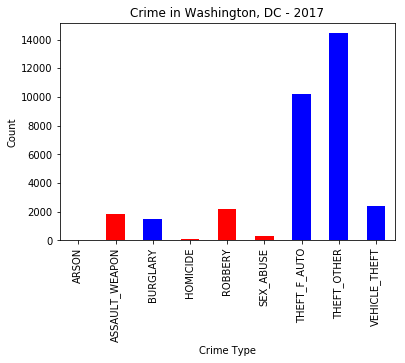

In [711]:
data['offense'].replace('ASSAULT W/DANGEROUS WEAPON', 'ASSAULT_WEAPON', inplace=True)
data['offense'].replace('MOTOR VEHICLE THEFT', 'VEHICLE_THEFT', inplace=True)
data['offense'].replace('SEX ABUSE', 'SEX_ABUSE', inplace=True)
data['offense'].replace('THEFT F/AUTO', 'THEFT_F_AUTO', inplace=True)
data['offense'].replace('THEFT/OTHER', 'THEFT_OTHER', inplace=True)

crimes = ['ARSON', 'ASSAULT_WEAPON', 'BURGLARY', 'HOMICIDE', 'VEHICLE_THEFT',
          'ROBBERY', 'SEX_ABUSE', 'THEFT_F_AUTO', 'THEFT_OTHER']

for crime in crimes:
    crime_flag=lambda x:1 if x==crime else 0
    data[crime] = data['offense'].map(crime_flag)
    
data.columns = map(str.lower, data.columns)
    
data['property_crime'] =  data['burglary'] + data['vehicle_theft'] + data['theft_f_auto'] + data['theft_other']
data['violent_crime'] = data['arson'] + data['assault_weapon'] + data['homicide'] + data['robbery'] + data['sex_abuse']

data['offense'] = data['offense'].astype('category')
categories = data['offense'].cat.categories
property_crimes = ['BURGLARY','VEHICLE_THEFT','THEFT_F_AUTO','THEFT_OTHER']

palette = ['b' if (x in property_crimes) else 'r' for x in categories]

import matplotlib.pyplot as plt
data['offense'].value_counts(sort=False).plot.bar(color=palette, title="Crime in Washington, DC - 2017")
plt.xlabel('Crime Type')
plt.ylabel('Count')

#### Explore relationship between Offense Type and Method

In [712]:
print(data['method'].value_counts())

OTHERS    30600
GUN        1570
KNIFE       817
Name: method, dtype: int64


From the cross tabulation heatmap below, we can see that guns and knives are used very rarely as a share of total crime with no reports of either of these methods used in property crimes. However, guns are used substantially in robberies and assaults with a dangerous weapon and account for a disproportionate share of homicides. Also, interestingly, the method associated with assaults with a danegrous weapon are generally equally distributed across guns, knives, and other methods.

Text(0.5,15,u'Method')

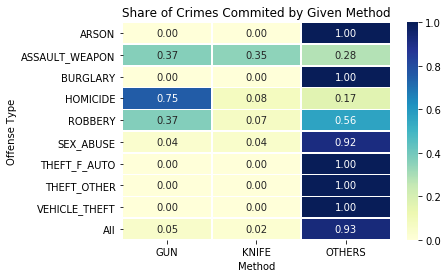

In [713]:
table=pd.crosstab(data['offense'], data['method'],normalize='index',margins=True)
import seaborn as sns
ax=sns.heatmap(table,yticklabels=True,linewidths=.5,annot=True,fmt='.2f',cmap="YlGnBu")
ax.set_title('Share of Crimes Commited by Given Method')
ax.set_ylabel('Offense Type')
ax.set_xlabel('Method')

Unsurprisingly, offense type and method are not independent of one another.

In [714]:
from scipy import stats
chi,p,df,expected = stats.chi2_contingency(observed=pd.crosstab(data['offense'], data['method']))
if p > 0.05:
    print('Offense type and method are independent')
else:
    print('Offense type and method are not independent')

Offense type and method are not independent


#### Explore relationship between Offense Type and race/ethnicity demographics of census tracts

In [715]:
nhw    = (pd.pivot_table(data, values='sharenhw', index='offense', aggfunc='mean', margins=True))
black  = (pd.pivot_table(data, values='shareblack', index='offense', aggfunc='mean', margins=True))
hisp   = (pd.pivot_table(data, values='sharehisp', index='offense', aggfunc='mean', margins=True))
anymin = (pd.pivot_table(data, values='sharemin', index='offense', aggfunc='mean', margins=True))

pd.concat([nhw, black, hisp, anymin],1)

sharenhw  shareblack  sharehisp  sharemin
offense                                                  
ARSON              0.365       0.483      0.102     0.635
ASSAULT_WEAPON     0.183       0.702      0.073     0.817
BURGLARY           0.287       0.573      0.086     0.713
HOMICIDE           0.121       0.793      0.059     0.879
ROBBERY            0.256       0.600      0.091     0.744
SEX_ABUSE          0.277       0.588      0.079     0.723
THEFT_F_AUTO       0.384       0.441      0.104     0.616
THEFT_OTHER        0.408       0.428      0.092     0.592
VEHICLE_THEFT      0.254       0.617      0.080     0.746
All                0.359       0.482      0.093     0.641

On average, crimes occured in census tracts that were majority minority (approximately 64% for all crimes). However, violent crimes occured in particularly high minority areas. For the top three violent crime categories, the average minority share of tracts in which was 82% for assaults with a dangerous weapon, 88% for homicides, and 74% for robberies.

Looking at the boxplot below, we see again that the median tract minority share is generally high for all crime types, but particularly high for violent crimes. In addition, crimes committed with guns or knives generally occur in higher minority tracts than crimes by other methods.

Text(0.5,1,u'Census Tract Minority Share Distribution by Offense Type & Method')

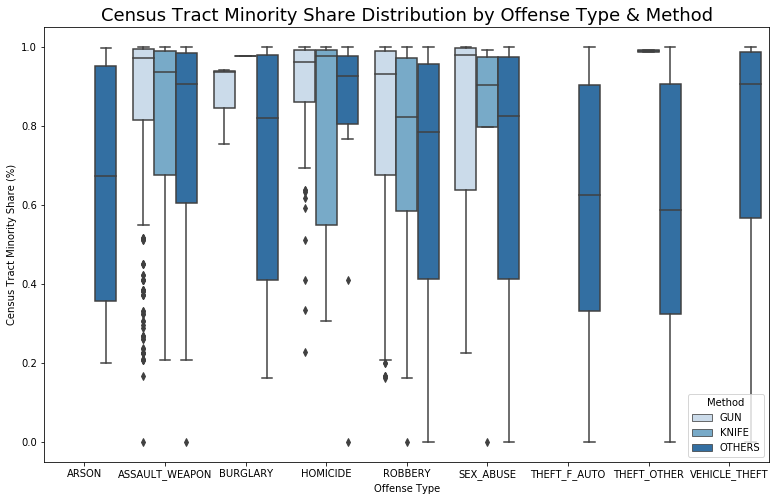

In [716]:
from matplotlib import pyplot
mydims = (13,8)
fig, ax = pyplot.subplots(figsize=mydims)
sns.boxplot(x='offense', y='sharemin', data=data, ax=ax, hue='method', palette='Blues')
plt.xlabel('Offense Type')
plt.ylabel('Census Tract Minority Share (%)')
plt.legend(title='Method',loc='lower right')
plt.title('Census Tract Minority Share Distribution by Offense Type & Method', size=18)

## Aggregate the Data by Census Tract

In [717]:
for i in range(0,len(crimes)):
    crimes[i] = crimes[i].lower()

print(crimes)
crimes.append('violent_crime')
crimes.append('property_crime')
vars = crimes[:]
vars.append('tract')
tractlevel_totalcrime = data[vars]
data_tract = tractlevel_totalcrime.groupby('tract').sum().reset_index()

covars = ['tract','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']
data_covars = data[covars]
data_covars = data_covars.groupby('tract').first().reset_index()

data_tractlevel = pd.merge(data_tract, data_covars, on='tract', validate='1:1', indicator=True, how='left')
print(data_tractlevel['_merge'].value_counts())
del data_tractlevel['_merge']

['arson', 'assault_weapon', 'burglary', 'homicide', 'vehicle_theft', 'robbery', 'sex_abuse', 'theft_f_auto', 'theft_other']
both          179
right_only      0
left_only       0
Name: _merge, dtype: int64


Convert raw crime numbers to a rate per 100,000 people in order to equalize across statistics across tract size.

In [718]:
for crime in crimes:
    data_tractlevel[crime+'_rate'] = (data_tractlevel[crime]/data_tractlevel['total_pop'])*100000

#### Violent crime by tract

From the distribution below, we see that there is at least one tract with an extremely high violent crime rate.

In [719]:
print(data_tractlevel['violent_crime_rate'].describe())
len(data_tractlevel[data_tractlevel.violent_crime_rate > 5000])

count      179.000
mean       818.939
std      1,252.007
min          0.000
25%        297.669
50%        602.773
75%        992.506
max     15,384.615
Name: violent_crime_rate, dtype: float64


1

In [720]:
extreme_outlier = data_tractlevel[data_tractlevel.violent_crime_rate > 5000].tract
print(extreme_outlier)
data_tractlevel.iloc[79,]

79   6,202.000
Name: tract, dtype: float64


tract                   6,202.000
arson                       0.000
assault_weapon              2.000
burglary                    0.000
homicide                    1.000
vehicle_theft              29.000
robbery                     5.000
sex_abuse                   2.000
theft_f_auto               47.000
theft_other               102.000
violent_crime              10.000
property_crime            178.000
total_pop                  65.000
sharenhw                    1.000
shareblack                  0.000
sharehisp                   0.000
sharemin                    0.000
hh_med_income                 nan
unemp_rate                  0.000
vacancy_rate                0.000
arson_rate                  0.000
assault_weapon_rate     3,076.923
burglary_rate               0.000
homicide_rate           1,538.462
vehicle_theft_rate     44,615.385
robbery_rate            7,692.308
sex_abuse_rate          3,076.923
theft_f_auto_rate      72,307.692
theft_other_rate      156,923.077
violent_crime_

The tract identified represents the National Mall and surrounding area. I exclude this area from any further analysis due to its very low tract population (65). Even though it does not see a significant nominal amount of violent or property crime, it's low tract population, in combination with the fact that it is a generally high traffic area, results in extremely high imputed crime rates.

In [721]:
data_tractlevel = data_tractlevel[data_tractlevel.tract != 6202.0].reset_index()

Looking at the histogram below, we see that the data is skewed with a long right tail and a few potential outliers with high violent crime rates.

count     178.000
mean      737.110
std       609.102
min         0.000
25%       297.122
50%       601.316
75%       984.688
max     3,253.922
Name: violent_crime_rate, dtype: float64


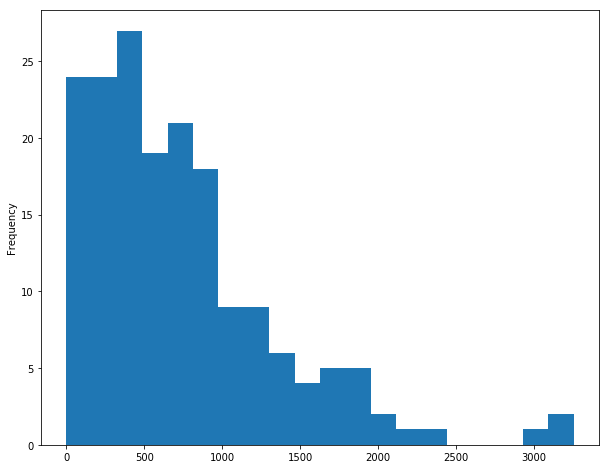

In [722]:
print(data_tractlevel['violent_crime_rate'].describe())
data_tractlevel['violent_crime_rate'].plot(kind='hist',bins=20,figsize=(10,8))

The boxplot confirms the presence of outliers in tract violent crime rates.

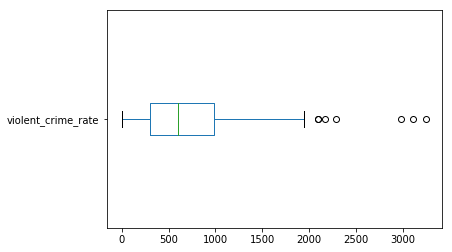

In [723]:
plot,outliers=data_tractlevel['violent_crime_rate'].plot.box(vert=False,return_type='both')

#### Investigate census tracts with high amounts of violent crime

In [724]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_vc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_vc'] = data_tractlevel['violent_crime_rate'].map(outliers_vc)


N = len(data_tractlevel)
index = list(range(0,N,1))

mylist = []
for i in index:
    if (data_tractlevel.out_vc[i]==2):
        mylist.append(data_tractlevel.tract[i])
        
outliers_table = data_tractlevel[data_tractlevel['tract'].isin(mylist)]
outliers_table = outliers_table[['tract','violent_crime','violent_crime_rate','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']]
display(outliers_table)

tract  violent_crime  violent_crime_rate  total_pop  sharenhw  \
77   5,800.000             58           2,094.619  2,769.000     0.627   
95   7,406.000             62           2,098.849  2,954.000     0.001   
110  7,803.000             85           2,292.959  3,707.000     0.016   
111  7,804.000             77           2,170.849  3,547.000     0.002   
129  8,803.000             73           3,114.334  2,344.000     0.233   
150  9,603.000            105           2,988.048  3,514.000     0.003   
173 10,700.000             56           3,253.922  1,721.000     0.775   

     shareblack  sharehisp  sharemin  hh_med_income  unemp_rate  vacancy_rate  
77        0.068      0.074     0.373    135,718.000       0.089         0.255  
95        0.906      0.074     0.999     30,000.000       0.086         0.205  
110       0.875      0.091     0.984     37,234.000       0.169         0.119  
111       0.932      0.049     0.998     45,396.000       0.147         0.157  
129       0.616      0.090     0.767     17,303.000       0.188         0.172  
150       0.959      0.027     0.997     40,551.000       0.194         0.106  
173       0.048      0.083     0.225     72,731.000       0.035         0.127

Above, I produce a table of tracts that are considered outliers based on the boxplot values. Five of the seven tracts identified as outliers have very high tract minority shares and generally low household median incomes, with four of these tracts reporting tract minority shares above 98%. The tract with the highest violent crime rate reports a very low household median income. Interestingly, we also have two oulier tracts report generally low minority shares and relatively high household median incomes. Unemployment rates and vacancy rates are a bit more varied. Below, I store the violent crime outlier tracts in the list "high_vc."

In [725]:
table_outvc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_vc'])

print(data_tractlevel['out_vc'].value_counts())
table_outvc.columns = ['normal', 'high_vc']
table_outvc.replace(0, np.nan,inplace=True)
high_vc = set(table_outvc["high_vc"].dropna().index)
high_vc

0    171
2      7
Name: out_vc, dtype: int64


{5800.0, 7406.0, 7803.0, 7804.0, 8803.0, 9603.0, 10700.0}

#### Property crime by tract

The histogram below shows a skewed distribution of property crime rates with a long right tail. In addition, the histogram indicates there are a few potential extreme property crime rate outliers.

count      178.000
mean     4,613.678
std      4,397.625
min         42.735
25%      2,156.938
50%      3,512.481
75%      5,584.404
max     35,933.550
Name: property_crime_rate, dtype: float64


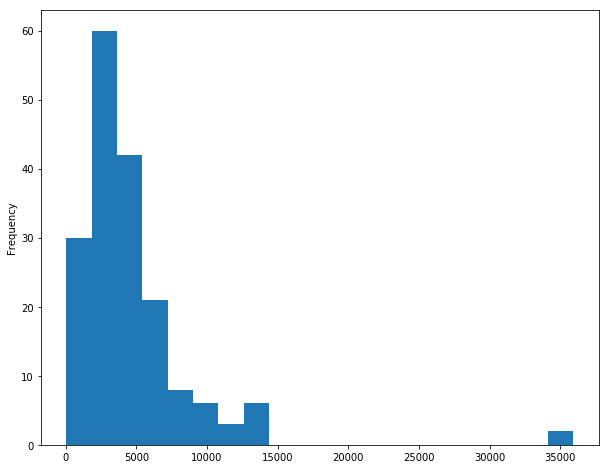

In [726]:
print(data_tractlevel['property_crime_rate'].describe())
data_tractlevel['property_crime_rate'].plot(kind='hist',bins=20,figsize=(10,8))

The boxplot confirms the presence of several outliers.

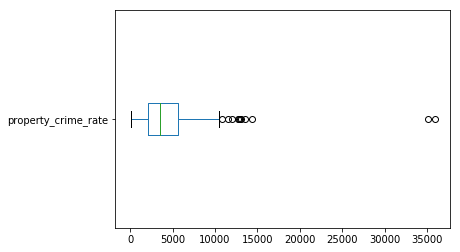

In [727]:
plot,outliers=data_tractlevel['property_crime_rate'].plot.box(vert=False,return_type='both')

In [728]:
len([flier.get_xdata() for flier in outliers["fliers"]][0])
[flier.get_xdata() for flier in outliers["fliers"]][0]
caps = [value.get_xdata()[0] for value in outliers["caps"]] 
lower_bound = caps[0]
upper_bound = caps[1]

outliers_pc = lambda x: 1 if (x<lower_bound) else 2 if (x>upper_bound) else np.nan if pd.isnull(x) else 0
data_tractlevel['out_pc'] = data_tractlevel['property_crime_rate'].map(outliers_pc)

mylist = []
for i in index:
    if (data_tractlevel.out_pc[i]==2):
        mylist.append(data_tractlevel.tract[i])
        
outliers_table = data_tractlevel[data_tractlevel['tract'].isin(mylist)]
outliers_table = outliers_table[['tract','property_crime','property_crime_rate','total_pop','sharenhw','shareblack','sharehisp','sharemin','hh_med_income','unemp_rate','vacancy_rate']]
display(outliers_table)

tract  property_crime  property_crime_rate  total_pop  sharenhw  \
2      202.000             575           13,017.885  4,417.000     0.773   
46   3,000.000             436           12,991.657  3,356.000     0.410   
63   4,400.000             798           14,375.788  5,551.000     0.677   
66   4,702.000             344           11,965.217  2,875.000     0.485   
77   5,800.000             995           35,933.550  2,769.000     0.627   
86   6,900.000             241           10,855.856  2,220.000     0.705   
129  8,803.000             318           13,566.553  2,344.000     0.233   
150  9,603.000             407           11,582.242  3,514.000     0.003   
167 10,100.000             335           12,655.837  2,647.000     0.578   
168 10,200.000             326           12,774.295  2,552.000     0.414   
173 10,700.000             605           35,153.980  1,721.000     0.775   

     shareblack  sharehisp  sharemin  hh_med_income  unemp_rate  vacancy_rate  
2         0.077      0.065     0.227    161,378.000       0.047         0.144  
46        0.458      0.094     0.590     77,609.000       0.091         0.097  
63        0.161      0.056     0.323    154,402.000       0.040         0.028  
66        0.374      0.072     0.515    100,179.000       0.047         0.048  
77        0.068      0.074     0.373    135,718.000       0.089         0.255  
86        0.223      0.049     0.295    124,045.000       0.003         0.074  
129       0.616      0.090     0.767     17,303.000       0.188         0.172  
150       0.959      0.027     0.997     40,551.000       0.194         0.106  
167       0.147      0.107     0.422     87,037.000       0.053         0.097  
168       0.396      0.072     0.586    101,250.000       0.058         0.129  
173       0.048      0.083     0.225     72,731.000       0.035         0.127

Above, I produce a table of tracts that are considered outliers based on the boxplot values. Compared to violent crime rate outliers, the distribution of tract minority share appears much more uniformly distributed, if not potentially trending to lower than average. In addition, with the exception of only two tracts (8803.0 and 9603.0), property crime rate outliers report generally high household median incomes, with several above $100,000. Furthermore, these same tracts report generally low unemployment rates and vacancy rates. Below, I store the property crime outlier tracts in the list "high_pc."

In [729]:
print(data_tractlevel['out_pc'].value_counts())
table_outpc=pd.crosstab(data_tractlevel['tract'],data_tractlevel['out_pc'])

table_outpc.columns = ['normal', 'high_pc']
table_outpc.replace(0, np.nan,inplace=True)
table_outpc
high_pc = set(table_outpc["high_pc"].dropna().index)
high_pc

0    167
2     11
Name: out_pc, dtype: int64


{202.0,
 3000.0,
 4400.0,
 4702.0,
 5800.0,
 6900.0,
 8803.0,
 9603.0,
 10100.0,
 10200.0,
 10700.0}

Four tracts are identified as outliers in both violent and property crime rates.

In [730]:
high_vc & high_pc

{5800.0, 8803.0, 9603.0, 10700.0}

In [731]:
assert data_tractlevel['hh_med_income'].isnull().sum() == 2
data_tractlevel_t = data_tractlevel[data_tractlevel.hh_med_income.notnull()]
assert len(data_tractlevel_t) == 176

In [732]:
for var in 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate':
    print('****************************************************************************')
    for type in 'out_pc', 'out_vc':
        print(pd.pivot_table(data_tractlevel, values=var, index=type, aggfunc='mean'))
        
        ttest_results = np.abs(stats.ttest_ind(data_tractlevel_t[data_tractlevel_t[type]==2][var],
                                               data_tractlevel_t[data_tractlevel_t[type]==0][var],
                                               equal_var=True))

        pval = ttest_results[1]
        if pval < 0.05:
            print('Difference in ' + var + ' is statistically significant between outliers and non-outliers')
        else:
            print('Difference in ' + var + ' is not statistically significant between outliers and non-outliers')

****************************************************************************
        sharemin
out_pc          
0          0.677
2          0.484
Difference in sharemin is statistically significant between outliers and non-outliers
        sharemin
out_vc          
0          0.661
2          0.763
Difference in sharemin is not statistically significant between outliers and non-outliers
****************************************************************************
        hh_med_income
out_pc               
0          77,085.370
2          97,473.000
Difference in hh_med_income is not statistically significant between outliers and non-outliers
        hh_med_income
out_vc               
0          79,363.053
2          54,133.286
Difference in hh_med_income is not statistically significant between outliers and non-outliers
****************************************************************************
        unemp_rate
out_pc            
0            0.108
2            0.077
Difference in u

Here, I examine how outlier tracts in violent and property crime compare to non-outlier tracts. While the differences in means of my key variables of interest between outliers and non-outliers is not generally statistically significant, interesting trends emerge. Tracts with the highest rates of violent crime have,on average, a tract minority share 10 percentage points greater than their counterparts, a household median income that is 20,000 USD lower, an unemployment rate that is 2.5 percentage points higher, and a vacancy rate that is 6.5 percentage points higher. By contrast, tracts with the highest rates of property crime, generally follow the opposite trend, with an almost 20 percentage point lower tract minority share, a 20,000 USD higher household median income, and a 2.5 percentage point lower unemployment rate.

Here, I produce a scatterplot matrix for all tracts between my variables of interest and key covariates. Violent crime rates, relative to property crime rates, appear to show stronger relationships with my covariates, though it would be difficult to categorize these relationships as linear.

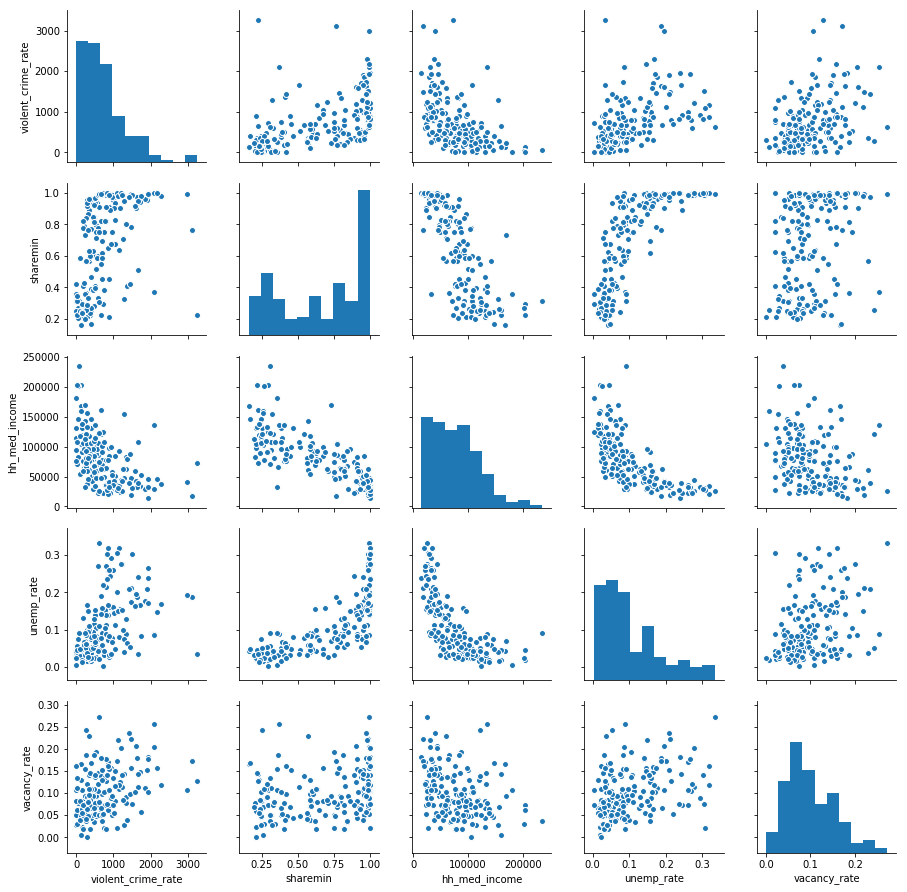

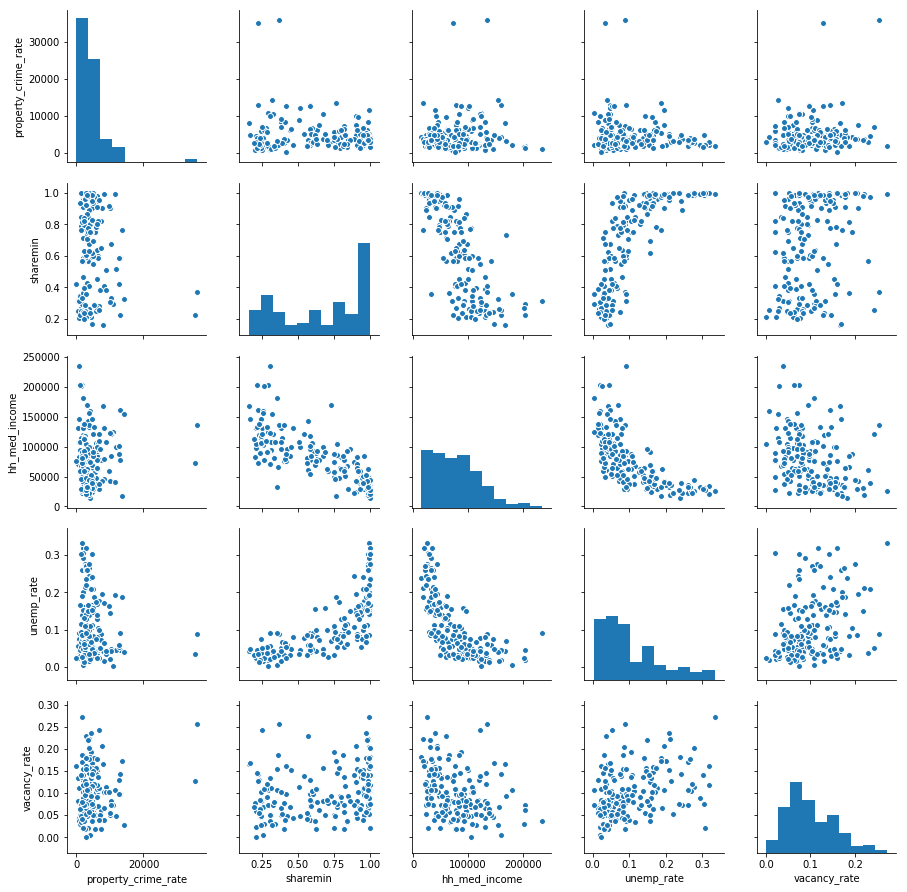

In [733]:
for crime in 'violent_crime_rate', 'property_crime_rate':
    cols=[crime, 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate']
    forgraph = pd.DataFrame(data_tractlevel, columns=cols)
    sns.pairplot(forgraph.dropna())    

In [734]:
for crime in 'violent_crime_rate', 'property_crime_rate':
    cols=[crime, 'sharemin', 'hh_med_income', 'unemp_rate', 'vacancy_rate']
    forcorr = pd.DataFrame(data_tractlevel, columns=cols)
    print('Pearson')
    print(forcorr.corr())
    print('*************************************************************************************')
    print('Spearman')
    print(forcorr.corr(method='spearman'))
    print('*************************************************************************************')

Pearson
                    violent_crime_rate  sharemin  hh_med_income  unemp_rate  \
violent_crime_rate               1.000     0.476         -0.498       0.453   
sharemin                         0.476     1.000         -0.791       0.742   
hh_med_income                   -0.498    -0.791          1.000      -0.690   
unemp_rate                       0.453     0.742         -0.690       1.000   
vacancy_rate                     0.385     0.263         -0.311       0.278   

                    vacancy_rate  
violent_crime_rate         0.385  
sharemin                   0.263  
hh_med_income             -0.311  
unemp_rate                 0.278  
vacancy_rate               1.000  
*************************************************************************************
Spearman
                    violent_crime_rate  sharemin  hh_med_income  unemp_rate  \
violent_crime_rate               1.000     0.621         -0.595       0.609   
sharemin                         0.621     1.000      

Violent crime rates appear generally moderately to strongly correlated with tract minority share, household median income, unemployment rate, and vacancy rate. By contrast, property crime rates are weakly correlated with these same tract characteristics. In addition, tract minority share is very highly correlated with household median income and the unemployment rate. Perhaps unsurprisingly, household median income is highly correlated with the unemployment rate.

## Cluster Analysis

Confirm that each row in the tract-level dataframe represents one tract.

In [735]:
len(data_tractlevel.tract.unique())==len(data_tractlevel)

True

Set the index to the tract number and check the storage types of the key covariates.

In [736]:
data_tractlevel.index = data_tractlevel.tract
data_tractlevel.loc[:,'sharemin':'vacancy_rate'].dtypes

sharemin         float64
hh_med_income    float64
unemp_rate       float64
vacancy_rate     float64
dtype: object

There are two tracts for which household median income data is missing. Drop these tracts here in order to perform the cluster analysis. Confirm the resulting dataframe has two less records than the main tract-level data frame.

In [737]:
print(data_tractlevel['hh_med_income'].isnull().sum())
data_cluster = data_tractlevel.dropna().copy()
assert len(data_cluster) == len(data_tractlevel) - 2

2


Here I prepare a similary matrix and apply the clustering technique.

In [738]:
from sklearn import preprocessing
tract_scaled = preprocessing.scale(data_cluster.loc[:,'sharemin':'vacancy_rate'])

In [739]:
from scipy.spatial.distance import pdist, squareform
tractSimi_simple = pdist(tract_scaled,metric='euclidean')
tractSimi_matrix =squareform(tractSimi_simple)

In [740]:
from scipy.cluster.hierarchy import linkage, cut_tree
tractSimi_link = linkage(tractSimi_simple,method='average')

Text(0.5,1,u'Cluster Analysis - All Covariates')

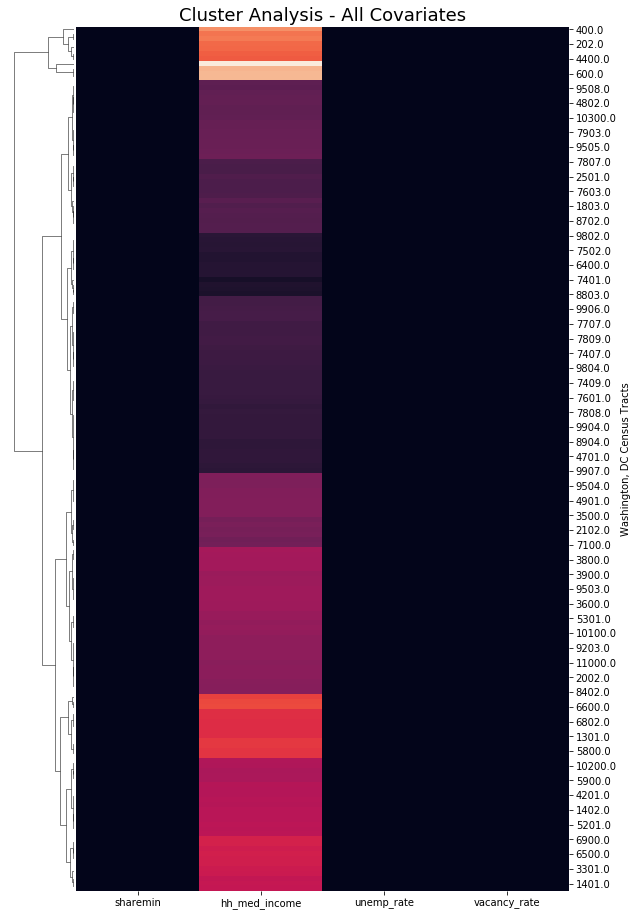

In [741]:
g = sns.clustermap(data_cluster.loc[:,'sharemin':'vacancy_rate'],
                   metric='euclidean',
                   method='average',
                   col_cluster=False,
                   figsize=(10, 20))


g.cax.set_visible(False)
col = g.ax_col_dendrogram.get_position()
g.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])

ax = g.ax_heatmap
ax.set_ylabel('Washington, DC Census Tracts')
ax.set_title('Cluster Analysis - All Covariates', size=18)

From the dendrogram above, tracts are more strongly separated by household median income than any of the other co-variates into three clusters. However, we should keep in mind that tract minority share and unemployment rate are very highly correlated with household median income. What does the dendrogram look like if we exclude household median income from the analysis? 

Text(0.5,1,u'Cluster Analysis - Exclude Household Median Income')

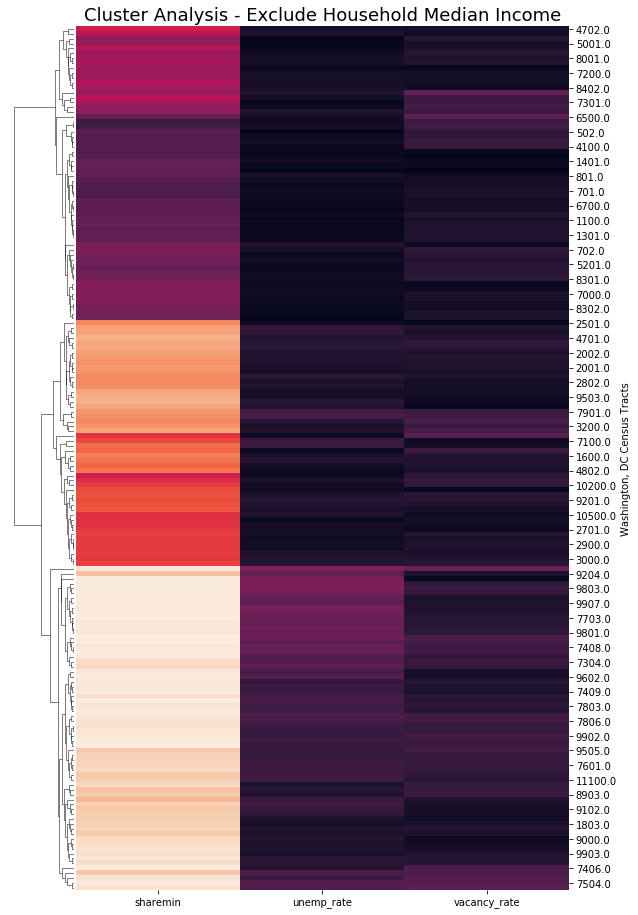

In [742]:
g_dropincome = sns.clustermap(data_cluster[['sharemin','unemp_rate','vacancy_rate']],
                   metric='euclidean',
                   method='average',
                   col_cluster=False,
                   figsize=(10, 20))

ax = g_dropincome.ax_heatmap
ax.set_ylabel('Washington, DC Census Tracts')

g_dropincome.cax.set_visible(False)
col = g_dropincome.ax_col_dendrogram.get_position()
g_dropincome.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.01])

ax = g_dropincome.ax_heatmap
ax.set_ylabel('Washington, DC Census Tracts')
ax.set_title('Cluster Analysis - Exclude Household Median Income', size=18)

When excluding household median income, tracts are strongly separated by tract minority share into approximately 3 clusters. Again, given the strong correlation between tract minority share and household median income, this result is unsurprising. Below, I calculate the average silhouette score for an increasing number of clusters. None of the silhouette scores are particularly high (all are below 0.5) suggesting the sample is very close to the decision boundary for even two clusters.

In [743]:
from sklearn.metrics import silhouette_score
from numpy import ravel

for nOfClusters in range(2,6):
    
    clusterLabels = ravel(cut_tree(tractSimi_link, nOfClusters))
    
    silhouette_avg = silhouette_score(tractSimi_matrix,clusterLabels,metric='precomputed')
    
    print("For n_clusters =", nOfClusters, 
          "The average silhouette score is:", silhouette_avg)

('For n_clusters =', 2, 'The average silhouette score is:', 0.41878936047348331)
('For n_clusters =', 3, 'The average silhouette score is:', 0.35819805918098652)
('For n_clusters =', 4, 'The average silhouette score is:', 0.27515120487888134)
('For n_clusters =', 5, 'The average silhouette score is:', 0.26560083239294952)


In [744]:
from sklearn.metrics import silhouette_samples

clusterLabels2=np.ravel(cut_tree(tractSimi_link, 2))
data_cluster['sil2']=silhouette_samples(tractSimi_matrix, clusterLabels2, metric='precomputed')

In [745]:
data_cluster.sil2.describe()

count   176.000
mean      0.419
std       0.273
min      -0.557
25%       0.332
50%       0.541
75%       0.604
max       0.645
Name: sil2, dtype: float64

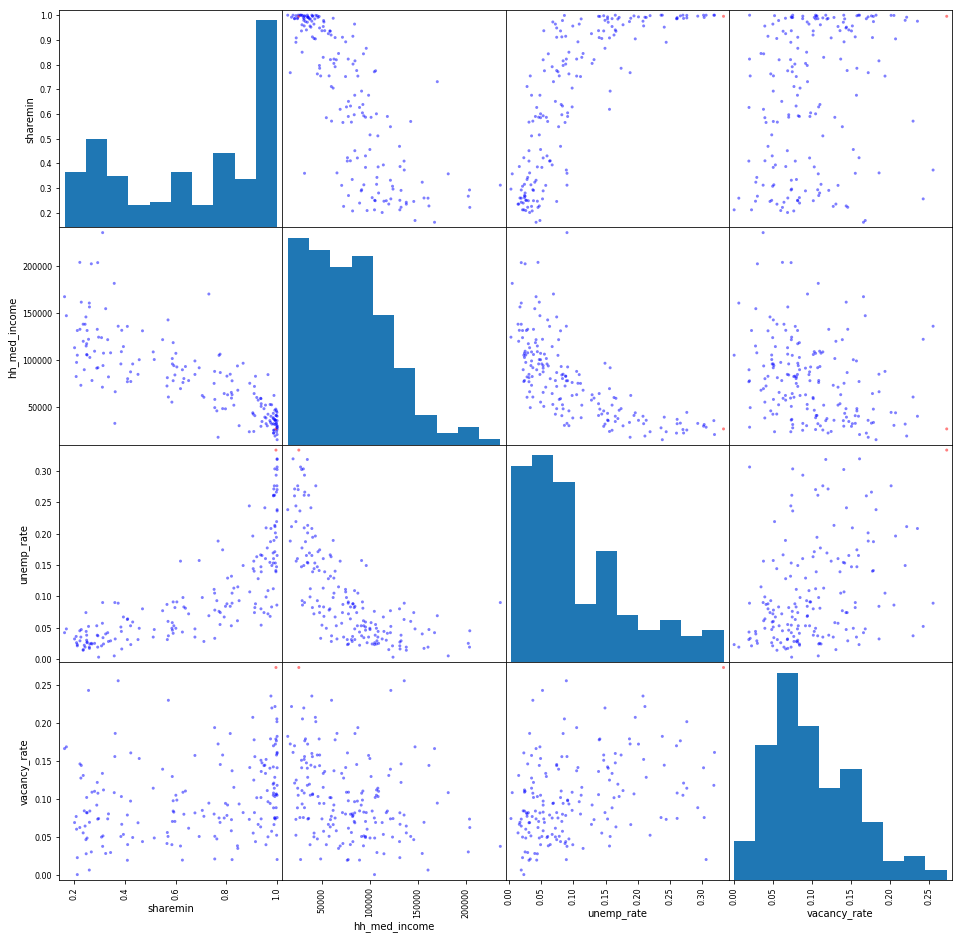

In [746]:
data_cluster.loc[:,'k2']=clusterLabels2
import matplotlib.pyplot as plt

myPalette = {0 : 'b',1 : 'r'}      
myColors = [myPalette[l] for l in data_cluster.loc[:,'k2']]

pd.plotting.scatter_matrix(data_cluster.loc[:,'sharemin':'vacancy_rate'],
                           figsize=(16, 16),
                           c=myColors)
plt.show()

From the scatterplot matrix above, there is evidently one tract that appears at the extremes of every covariate category, ending up in a cluster by itself. This tract appears to have a very high tract minority share, low household median income, very high unemployment rate, and very high vacancy rate.

In [747]:
vacancy_rate_max = data_cluster.vacancy_rate.max()
lonetract = data_cluster[data_cluster.vacancy_rate == vacancy_rate_max]
lonetract = lonetract[['tract','sharemin','hh_med_income','unemp_rate','vacancy_rate', 'sil2']]
display(lonetract)

tract  sharemin  hh_med_income  unemp_rate  vacancy_rate  sil2
tract                                                                       
9,802.000 9,802.000     0.995     26,205.000       0.333         0.273 0.000

The tract in question is tract 98.02, which is located in the Southeast quandrant of Washington, DC close to the district's southeast border with Maryland.

## Regression Analysis

#### Logistic Regression

As with the above analyses, exclude tract 6202, which represents the National Mall and surrouding area.

In [748]:
data = data[data.tract != 6202.0].reset_index()

Confirm the binary offense type columns created at the top of the program only take on values of 0 or 1.

In [749]:
for crime in crimes:
    for values in data[crime]:      
        if (values!=0):
            assert values==1

The main independent variable of interest is tract minority share. Here, I create a binary indicator for whether or not the tract is majority minority, which I define as having a tract minority share above 50%.

In [750]:
print(data.sharemin.describe())

data['majmin_tract'] = data.sharemin > 0.50
data['majmin_tract'] = data['majmin_tract'].astype('int')

count   32,799.000
mean         0.645
std          0.287
min          0.161
25%          0.373
50%          0.676
75%          0.937
max          1.000
Name: sharemin, dtype: float64


For household median income, I create four separate categories. Tracts will be considered high income if they have a median household income greater than or equal to 100,000 USD, middle income if they have a household median income less than 100,000 USD and greater than or equal to 40,000 USD, and low income if they have a median household income below 40,000 USD. To include the two tracts for which income data is missing, I create a fourth income missing category.

In [751]:
print(data.hh_med_income.describe())

income_cat = lambda x: 'income_high' if (x>=100000) \
                  else 'income_middle' if (x<100000 and x>=40000) \
                  else 'income_low' if (x<40000) \
                  else 'income_missing' if pd.isnull(x) \
                  else 'check_me'

count    32,731.000
mean     80,428.604
std      42,005.321
min      14,692.000
25%      42,054.000
50%      77,609.000
75%     106,806.000
max     235,517.000
Name: hh_med_income, dtype: float64


In [752]:
data['income_cat'] = data['hh_med_income'].map(income_cat)
data['income_cat'].value_counts()

income_middle     16029
income_high       10022
income_low         6680
income_missing       68
Name: income_cat, dtype: int64

For unemployment rate, I create two categories based on whether or not the tract unemployment rate is above the average 2016 national unemployment rate (4.9%), as reported by the Bureau of Labor Statistics.

In [753]:
print(data.unemp_rate).describe()

unemp_cat = lambda x: 'unemp_belownatl' if (x<=0.046) \
                 else 'unemp_abovenatl' if (x>0.046) \
                 else 'unemp_missing' if pd.isnull(x) \
                 else 'check_me'

count   32,799.000
mean         0.101
std          0.075
min          0.003
25%          0.043
50%          0.080
75%          0.153
max          0.486
Name: unemp_rate, dtype: float64


In [754]:
data['unemp_cat'] = data['unemp_rate'].map(unemp_cat)
data['unemp_cat'].value_counts()

unemp_abovenatl    23560
unemp_belownatl     9239
Name: unemp_cat, dtype: int64

For vacancy rate, I create three categories. Tracts are considered low vacancy if they have a vacancy rate less than or equal to 6%, middle vacancy if they have a vacancy rate greater than 6% and less than 14%, and high vacancy if they have a vacancy rate above 14%.

In [755]:
print(data.vacancy_rate).describe()

vacancy_cat = lambda x: 'vacancy_low' if (x<=0.06) \
                   else 'vacancy_middle' if (x>0.06 and x <=0.14) \
                   else 'vacancy_high' if (x>0.14) \
                   else 'vacancy_missing' if pd.isnull(x) \
                   else 'check_me'

count   32,799.000
mean         0.105
std          0.057
min          0.000
25%          0.062
50%          0.101
75%          0.143
max          0.273
Name: vacancy_rate, dtype: float64


In [756]:
data['vacancy_cat'] = data['vacancy_rate'].map(vacancy_cat)
data['vacancy_cat'].value_counts()

vacancy_middle    15966
vacancy_high       8913
vacancy_low        7920
Name: vacancy_cat, dtype: int64

Here, I define a series of logistic regression models. Model 0 controls only for whether or not the tract is majority minority. For models with additional covariates, high income tracts serve as the base group for household median income; tracts with unemployment rates below the 2016 national average serve as the base group for unemployment rate; and low vacancy tracts serve as the base group for vacancy rate.

In [757]:
from statsmodels.formula.api import logit
model0=' ~ majmin_tract'
model1=' ~ majmin_tract + C(income_cat, Treatment("income_high"))'
model2=' ~ majmin_tract + C(income_cat, Treatment("income_high")) + C(unemp_cat, Treatment("unemp_belownatl"))'
model3=' ~ majmin_tract + C(income_cat, Treatment("income_high")) + C(unemp_cat, Treatment("unemp_belownatl")) + C(vacancy_cat, Treatment("vacancy_low"))'
model4=' ~ majmin_tract + C(income_cat, Treatment("income_high")) +                                              C(vacancy_cat, Treatment("vacancy_low"))'
model5=' ~ majmin_tract +                                           C(unemp_cat, Treatment("unemp_belownatl")) + C(vacancy_cat, Treatment("vacancy_low"))'

In [758]:
c = ['violent_crime', 'property_crime']

Below, I define a series of functions to clean up the regression results table I produce in the loop below. The function "to_sort" prepares a standardized ordering of the indepedent variables in my models. The fucntion "rename" recodes the independent variable names to be more reader-friendly.

In [759]:
to_sort = lambda x:  0 if (x==u'majmin_tract') \
                else 1 if (x==u'C(income_cat, Treatment("income_high"))[T.income_low]') \
                else 2 if (x==u'C(income_cat, Treatment("income_high"))[T.income_middle]') \
                else 3 if (x==u'C(income_cat, Treatment("income_high"))[T.income_missing]') \
                else 4 if (x==u'C(unemp_cat, Treatment("unemp_belownatl"))[T.unemp_abovenatl]') \
                else 5 if (x==u'C(vacancy_cat, Treatment("vacancy_low"))[T.vacancy_middle]') \
                else 6 if (x==u'C(vacancy_cat, Treatment("vacancy_low"))[T.vacancy_high]') \
                else 7 if (x==u'Intercept') \
                else 'check_me'

In [760]:
rename = lambda x:   'Majority Minority Tract (> 50%)' if (x==u'majmin_tract') \
                else 'Median HH Income < 40,000' if (x==u'C(income_cat, Treatment("income_high"))[T.income_low]') \
                else '40,000 < Median HH Income < 100,000' if (x==u'C(income_cat, Treatment("income_high"))[T.income_middle]') \
                else 'Median HH Income Missing' if (x==u'C(income_cat, Treatment("income_high"))[T.income_missing]') \
                else 'Unemployment Rate > National Average' if (x==u'C(unemp_cat, Treatment("unemp_belownatl"))[T.unemp_abovenatl]') \
                else '6% < Vacancy Rate <= 14%' if (x==u'C(vacancy_cat, Treatment("vacancy_low"))[T.vacancy_middle]') \
                else 'Vacancy Rate > 14%' if (x==u'C(vacancy_cat, Treatment("vacancy_low"))[T.vacancy_high]') \
                else 'Intercept' if (x==u'Intercept') \
                else 'check_me'

Below, I have created a loop that regresses violent crime and property crime against each of the six models defined above. For each iteration of the model loop, the odds ratios and p-values are stored in the dictionary "dall," while the AIC values are stored in the dictionary "daic." For each crime type, these results are then saved as an appropriately named pandas dataframe and formatted using the pre-defined functions above. 

In [761]:
for dv in c:
   
    ors = {}
    aic = {}

    dall = {}
    daic = {} 
    
    i=0
    
    for model in model0, model1, model2, model3, model4, model5:
      
        tmp = logit((dv + model),data=data).fit()

        stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

        print('*****************************************************')
        print(dv + 'Model: ' + str(i))
        print(tmp.summary())

        ors[i] = {'OR Model ' + str(i):np.exp(tmp.params).round(2),
                  'P-Val Model ' + str(i):tmp.pvalues.round(3)}

        aic[i] = {'Model ' + str(i):tmp.aic.round(3)}

        dall.update(ors[i])
        daic.update(aic[i])

        i=i+1
        
    results=pd.DataFrame.from_dict(dall)
    results=results[['OR Model 0', 'P-Val Model 0', 
                     'OR Model 1', 'P-Val Model 1',
                     'OR Model 2', 'P-Val Model 2',
                     'OR Model 3', 'P-Val Model 3',
                     'OR Model 4', 'P-Val Model 4',
                     'OR Model 5', 'P-Val Model 5']]
    
    results['to_sort'] = results.index.map(to_sort)
    results = results.sort_values('to_sort')
    results = results.fillna('-')
    del results['to_sort']

    results.index = results.index.map(rename)

    aic=pd.DataFrame(daic,index=['AIC'])
    
    if dv == 'violent_crime':
        vc_results = results
        vc_aic = aic
    
    if dv == 'property_crime':
        pc_results = results
        pc_aic = aic
    

Optimization terminated successfully.
         Current function value: 0.383096
         Iterations 7
*****************************************************
violent_crimeModel: 0
                           Logit Regression Results                           
Dep. Variable:          violent_crime   No. Observations:                32799
Model:                          Logit   Df Residuals:                    32797
Method:                           MLE   Df Model:                            1
Date:                Sat, 03 Mar 2018   Pseudo R-squ.:                 0.02817
Time:                        18:27:08   Log-Likelihood:                -12565.
converged:                       True   LL-Null:                       -12929.
                                        LLR p-value:                1.928e-160
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -2.5803     

Optimization terminated successfully.
         Current function value: 0.381012
         Iterations 7
*****************************************************
violent_crimeModel: 5
                           Logit Regression Results                           
Dep. Variable:          violent_crime   No. Observations:                32799
Model:                          Logit   Df Residuals:                    32794
Method:                           MLE   Df Model:                            4
Date:                Sat, 03 Mar 2018   Pseudo R-squ.:                 0.03346
Time:                        18:27:14   Log-Likelihood:                -12497.
converged:                       True   LL-Null:                       -12929.
                                        LLR p-value:                5.847e-186
                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

Optimization terminated successfully.
         Current function value: 0.376111
         Iterations 7
*****************************************************
property_crimeModel: 4
                           Logit Regression Results                           
Dep. Variable:         property_crime   No. Observations:                32799
Model:                          Logit   Df Residuals:                    32792
Method:                           MLE   Df Model:                            6
Date:                Sat, 03 Mar 2018   Pseudo R-squ.:                 0.04589
Time:                        18:27:19   Log-Likelihood:                -12336.
converged:                       True   LL-Null:                       -12929.
                                        LLR p-value:                3.709e-253
                                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------

#### Violent Crime Results

From the results below, majority minority tracts are 2.73 times as likely to experience violent crime as non-majority minority tracts, when not controlling for any other tract characteristics. This result is statistically significant at the 5% level. After controlling for tract characteristics, the odds ratio drops to between 1.67-1.71 for models, 1 through 4 and remains statistically significant across models. For the covariates, unemployment rate is not statistically significant and does not appear to be a strong predictor of violent crime, hence it's removal from model 4, which also presents the lowest AIC values (though it is not meterially lower than model 3).

The implications for these results suggest that majority minority tracts are 1.69 times as likely to experience violent crime as non-majority minority tracts, all else equal across median household income, the unemployment rate, and vacancy rate. Given the simplicity of these models, the models below likely suffer from omitted variable bias as there is likely some strong driver of violent crime that is not captured by or strongly correlated with median household income, the unemployment rate, or the vacancy rate.

In [762]:
pd.options.display.float_format = '{:,.3f}'.format
display(vc_results)
display(vc_aic)

OR Model 0 P-Val Model 0 OR Model 1  \
Majority Minority Tract (> 50%)           2.730         0.000      1.690   
Median HH Income < 40,000                     -             -      3.000   
40,000 < Median HH Income < 100,000           -             -      1.640   
Median HH Income Missing                      -             -      6.170   
Unemployment Rate > National Average          -             -          -   
6% < Vacancy Rate <= 14%                      -             -          -   
Vacancy Rate > 14%                            -             -          -   
Intercept                                 0.080         0.000      0.060   

                                     P-Val Model 1 OR Model 2 P-Val Model 2  \
Majority Minority Tract (> 50%)              0.000      1.670         0.000   
Median HH Income < 40,000                    0.000      2.990         0.000   
40,000 < Median HH Income < 100,000          0.000      1.640         0.000   
Median HH Income Missing                     0.000      6.120         0.000   
Unemployment Rate > National Average             -      1.020         0.677   
6% < Vacancy Rate <= 14%                         -          -             -   
Vacancy Rate > 14%                               -          -             -   
Intercept                                    0.000      0.060         0.000   

                                      OR Model 3  P-Val Model 3 OR Model 4  \
Majority Minority Tract (> 50%)            1.710          0.000      1.690   
Median HH Income < 40,000                  2.780          0.000      2.770   
40,000 < Median HH Income < 100,000        1.660          0.000      1.660   
Median HH Income Missing                   7.460          0.000      7.410   
Unemployment Rate > National Average       0.980          0.689          -   
6% < Vacancy Rate <= 14%                   1.220          0.000      1.220   
Vacancy Rate > 14%                         1.400          0.000      1.400   
Intercept                                  0.050          0.000      0.050   

                                     P-Val Model 4 OR Model 5 P-Val Model 5  
Majority Minority Tract (> 50%)              0.000      2.540         0.000  
Median HH Income < 40,000                    0.000          -             -  
40,000 < Median HH Income < 100,000          0.000          -             -  
Median HH Income Missing                     0.000          -             -  
Unemployment Rate > National Average             -      1.090         0.126  
6% < Vacancy Rate <= 14%                     0.000      1.270         0.000  
Vacancy Rate > 14%                           0.000      1.680         0.000  
Intercept                                    0.000      0.060         0.000

Model 0    Model 1    Model 2    Model 3    Model 4    Model 5
AIC 25,134.330 24,726.319 24,728.145 24,687.989 24,686.149 25,003.625

#### Property Crime Results

Ineterestingly, property crime presents an opposite trend. From the results below, majority minority tracts are 0.37 times as likely to experience property crime as non-majority minority tracts, when not controlling for any other tract characteristics. This result is statistically significant at the 5% level. After controlling for tract characteristics, this odds ratio increases to between 0.58-0.60 for models 1 through 4 and remains statistically significant. For the covariates, unemployment rate is again not statistically significant and does not appear to be a strong predictor of property crime. Model 4 again presents the lowest AIC value.

The implications for these results suggest that majority minority tracts are 0.59 times as likely to experience property crime as non-majority minority tracts, all else equal across median household income, the unemployment rate, and vacancy rate.

In [763]:
pd.options.display.float_format = '{:,.3f}'.format
display(pc_results)
display(pc_aic)

OR Model 0 P-Val Model 0 OR Model 1  \
Majority Minority Tract (> 50%)           0.370         0.000      0.590   
Median HH Income < 40,000                     -             -      0.330   
40,000 < Median HH Income < 100,000           -             -      0.610   
Median HH Income Missing                      -             -      0.160   
Unemployment Rate > National Average          -             -          -   
6% < Vacancy Rate <= 14%                      -             -          -   
Vacancy Rate > 14%                            -             -          -   
Intercept                                13.200         0.000     16.170   

                                     P-Val Model 1 OR Model 2 P-Val Model 2  \
Majority Minority Tract (> 50%)              0.000      0.600         0.000   
Median HH Income < 40,000                    0.000      0.330         0.000   
40,000 < Median HH Income < 100,000          0.000      0.610         0.000   
Median HH Income Missing                     0.000      0.160         0.000   
Unemployment Rate > National Average             -      0.980         0.677   
6% < Vacancy Rate <= 14%                         -          -             -   
Vacancy Rate > 14%                               -          -             -   
Intercept                                    0.000     16.290         0.000   

                                      OR Model 3  P-Val Model 3 OR Model 4  \
Majority Minority Tract (> 50%)            0.580          0.000      0.590   
Median HH Income < 40,000                  0.360          0.000      0.360   
40,000 < Median HH Income < 100,000        0.600          0.000      0.600   
Median HH Income Missing                   0.130          0.000      0.130   
Unemployment Rate > National Average       1.020          0.689          -   
6% < Vacancy Rate <= 14%                   0.820          0.000      0.820   
Vacancy Rate > 14%                         0.710          0.000      0.710   
Intercept                                 19.270          0.000     19.400   

                                     P-Val Model 4 OR Model 5 P-Val Model 5  
Majority Minority Tract (> 50%)              0.000      0.390         0.000  
Median HH Income < 40,000                    0.000          -             -  
40,000 < Median HH Income < 100,000          0.000          -             -  
Median HH Income Missing                     0.000          -             -  
Unemployment Rate > National Average             -      0.920         0.126  
6% < Vacancy Rate <= 14%                     0.000      0.790         0.000  
Vacancy Rate > 14%                           0.000      0.600         0.000  
Intercept                                    0.000     17.610         0.000

Model 0    Model 1    Model 2    Model 3    Model 4    Model 5
AIC 25,134.330 24,726.319 24,728.145 24,687.989 24,686.149 25,003.625

## Mapping Crime

In [764]:
%matplotlib inline
import geopandas as gpd
import matplotlib.pyplot as plt

In [765]:
import pysal as ps

Import the 2017 Washington, DC water shapefile, which can be downloaded [here.](ftp://ftp2.census.gov/geo/tiger/TIGER2017/AREAWATER/)

In [766]:
compressedwater = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11001_areawater.zip'
dcwatermap = gpd.GeoDataFrame.from_file(compressedwater)
dcwatermap.head()

ANSICODE       HYDROID          FULLNAME  MTFCC  ALAND  AWATER     INTPTLAT  \
0           110431721909  Washington Chnnl  H3010      0  860314  +38.8625888   
1           110431721799          Rock Crk  H3010      0   43194  +38.9380700   
2           110431722007                    H2030      0     746  +38.9515500   
3           110431722012                    H2030      0     428  +38.9214634   
4           110431722025                    H2030      0      94  +38.9263534   

      INTPTLON                                           geometry  
0  -77.0216740  POLYGON ((-77.03260999999999 38.882295, -77.03...  
1  -77.0522080  POLYGON ((-77.05220799999999 38.93807, -77.052...  
2  -76.9851238  POLYGON ((-76.98543699999999 38.951356, -76.98...  
3  -76.9793510  POLYGON ((-76.979541 38.92151399999999, -76.97...  
4  -77.1105083  POLYGON ((-77.110562 38.926461, -77.110539 38....

Import the 2017 Washington, DC primary roads shapefile, which can be downloaded [here.](ftp://ftp2.census.gov/geo/tiger/TIGER2017/ROADS/)

In [767]:
compressedroads = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11001_roads.zip'
dcroadmap = gpd.GeoDataFrame.from_file(compressedroads)
dcroadmap.head()

LINEARID      FULLNAME RTTYP  MTFCC  \
0  1104492433987  US Hwy 1 Alt     U  S1200   
1  1104486393160  US Hwy 1 Alt     U  S1200   
2  1104486393165  US Hwy 1 Alt     U  S1200   
3  1104486393158  US Hwy 1 Alt     U  S1200   
4  1104492433988  US Hwy 1 Alt     U  S1200   

                                            geometry  
0  LINESTRING (-76.957756 38.93074899999999, -76....  
1  LINESTRING (-77.000573 38.89308799999999, -77....  
2  LINESTRING (-77.00057699999999 38.893403999999...  
3  LINESTRING (-76.99845399999998 38.893965, -76....  
4  LINESTRING (-76.957667 38.93068099999999, -76....

For the maps produced below, I am no interested in plotting all of the roads in Washington, DC, as this would make the maps difficult to read and potentially obstruct more important information. As such, I drop municipal roads (known as common name roads by the U.S. Census Bureau) and roads missing a route type code from the dataframe. Now, my dataframe will only contain interstates (I), state routes (S), and U.S. routes (U).

In [768]:
print(dcroadmap.RTTYP.value_counts())
dcroadmap = dcroadmap[dcroadmap.RTTYP != 'M']
dcroadmap = dcroadmap[dcroadmap.RTTYP != '']

M    3512
      882
U      58
I      20
S       6
Name: RTTYP, dtype: int64


Import the 2017 Washington, DC Census tract shapefile, which can be downloaded [here.](ftp://ftp2.census.gov/geo/tiger/TIGER2017/TRACT/)

In [769]:
compressedmap = 'https://github.com/qziegler/data/raw/master/raw/2017_DCShapeFiles/tl_2017_11_tract.zip'
dctractmap = gpd.GeoDataFrame.from_file(compressedmap)
dctractmap.TRACTCE = dctractmap.TRACTCE.astype('float64')
dctractmap.head()

STATEFP COUNTYFP    TRACTCE        GEOID   NAME            NAMELSAD  MTFCC  \
0      11      001 10,900.000  11001010900    109    Census Tract 109  G5020   
1      11      001 10,400.000  11001010400    104    Census Tract 104  G5020   
2      11      001  9,903.000  11001009903  99.03  Census Tract 99.03  G5020   
3      11      001  9,904.000  11001009904  99.04  Census Tract 99.04  G5020   
4      11      001  9,905.000  11001009905  99.05  Census Tract 99.05  G5020   

  FUNCSTAT    ALAND   AWATER     INTPTLAT      INTPTLON  \
0        S  2379832  2936613  +38.8132450  -077.0238468   
1        S  2744444       83  +38.8499425  -077.0004103   
2        S   383679        0  +38.8883180  -076.9212121   
3        S   426198        0  +38.8851712  -076.9311353   
4        S   431557        0  +38.8843295  -076.9250522   

                                            geometry  
0  POLYGON ((-77.039191 38.800496, -77.03913 38.8...  
1  POLYGON ((-77.009191 38.839184, -77.0091549999...  
2  POLYGON ((-76.930054 38.88982, -76.927966 38.8...  
3  POLYGON ((-76.935773 38.885964, -76.935243 38....  
4  POLYGON ((-76.929322 38.880769, -76.92925 38.8...

Here, I merge the geographic data I will use for plotting with the tract-level dataframe prepared at the top of the program. The merge variable indicates there is one tract present in our geographic data, which is not present in our tract-level data. I confirm this is tract 6202, which represents the National Mall and surrounding area, which I expressly excluded from all tract-level analyses.

In [770]:
crimeratemap = dctractmap.merge(data_tractlevel, how='left', left_on='TRACTCE', right_on='tract', validate ='1:1', indicator=True)
crimeratemap['_merge'].value_counts()

both          178
left_only       1
right_only      0
Name: _merge, dtype: int64

In [771]:
print(crimeratemap[crimeratemap._merge=='left_only'].TRACTCE)

94   6,202.000
Name: TRACTCE, dtype: float64


### Maps - Crime Rates by Census Tract

Here, I create two maps representing the tract-level violent crime rate and property crime rate, respectively. Tract coloring is a function of which quantile (5) the tract crime rate falls within; for example, yellow represents tracts within the highest quantile of the respective crime rate, while black represents tracts within the lowest quantile.

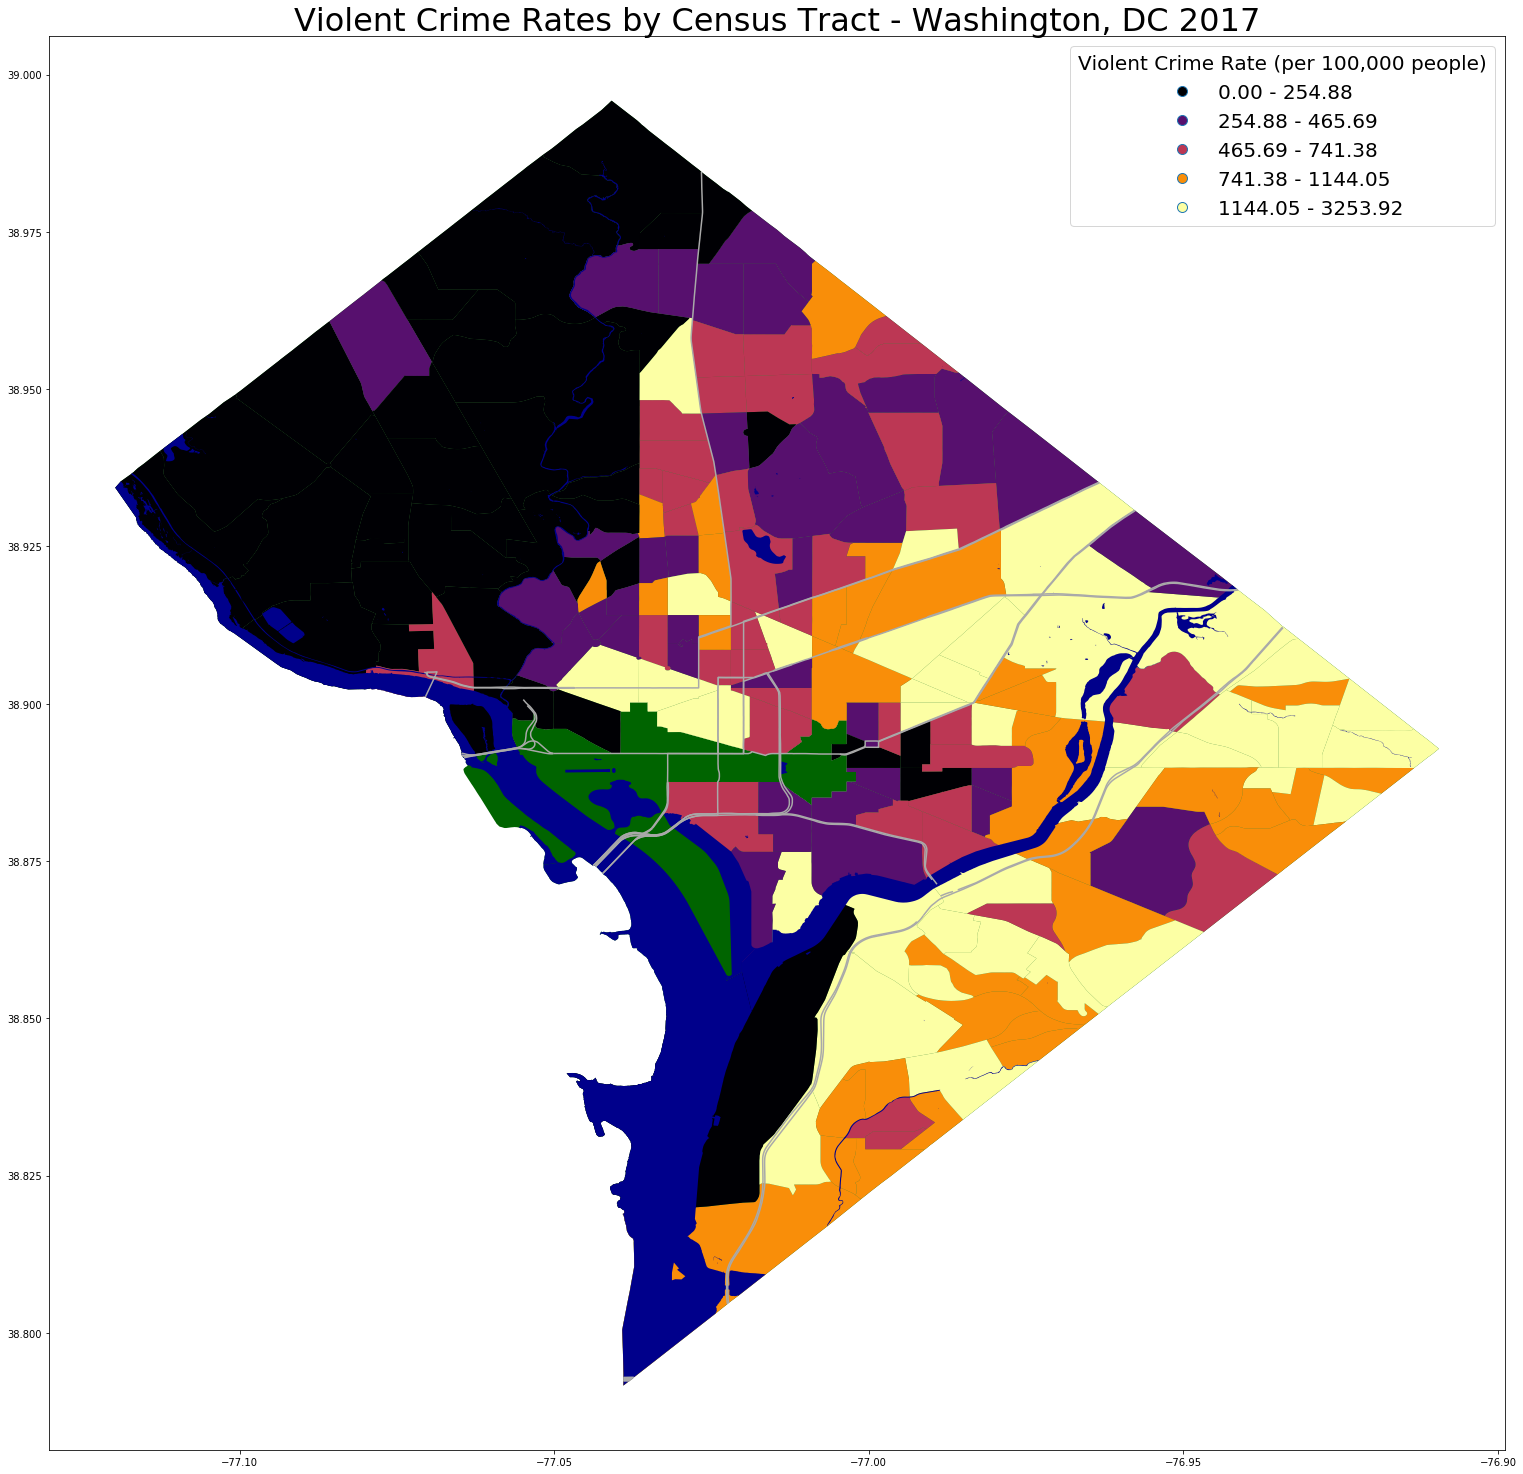

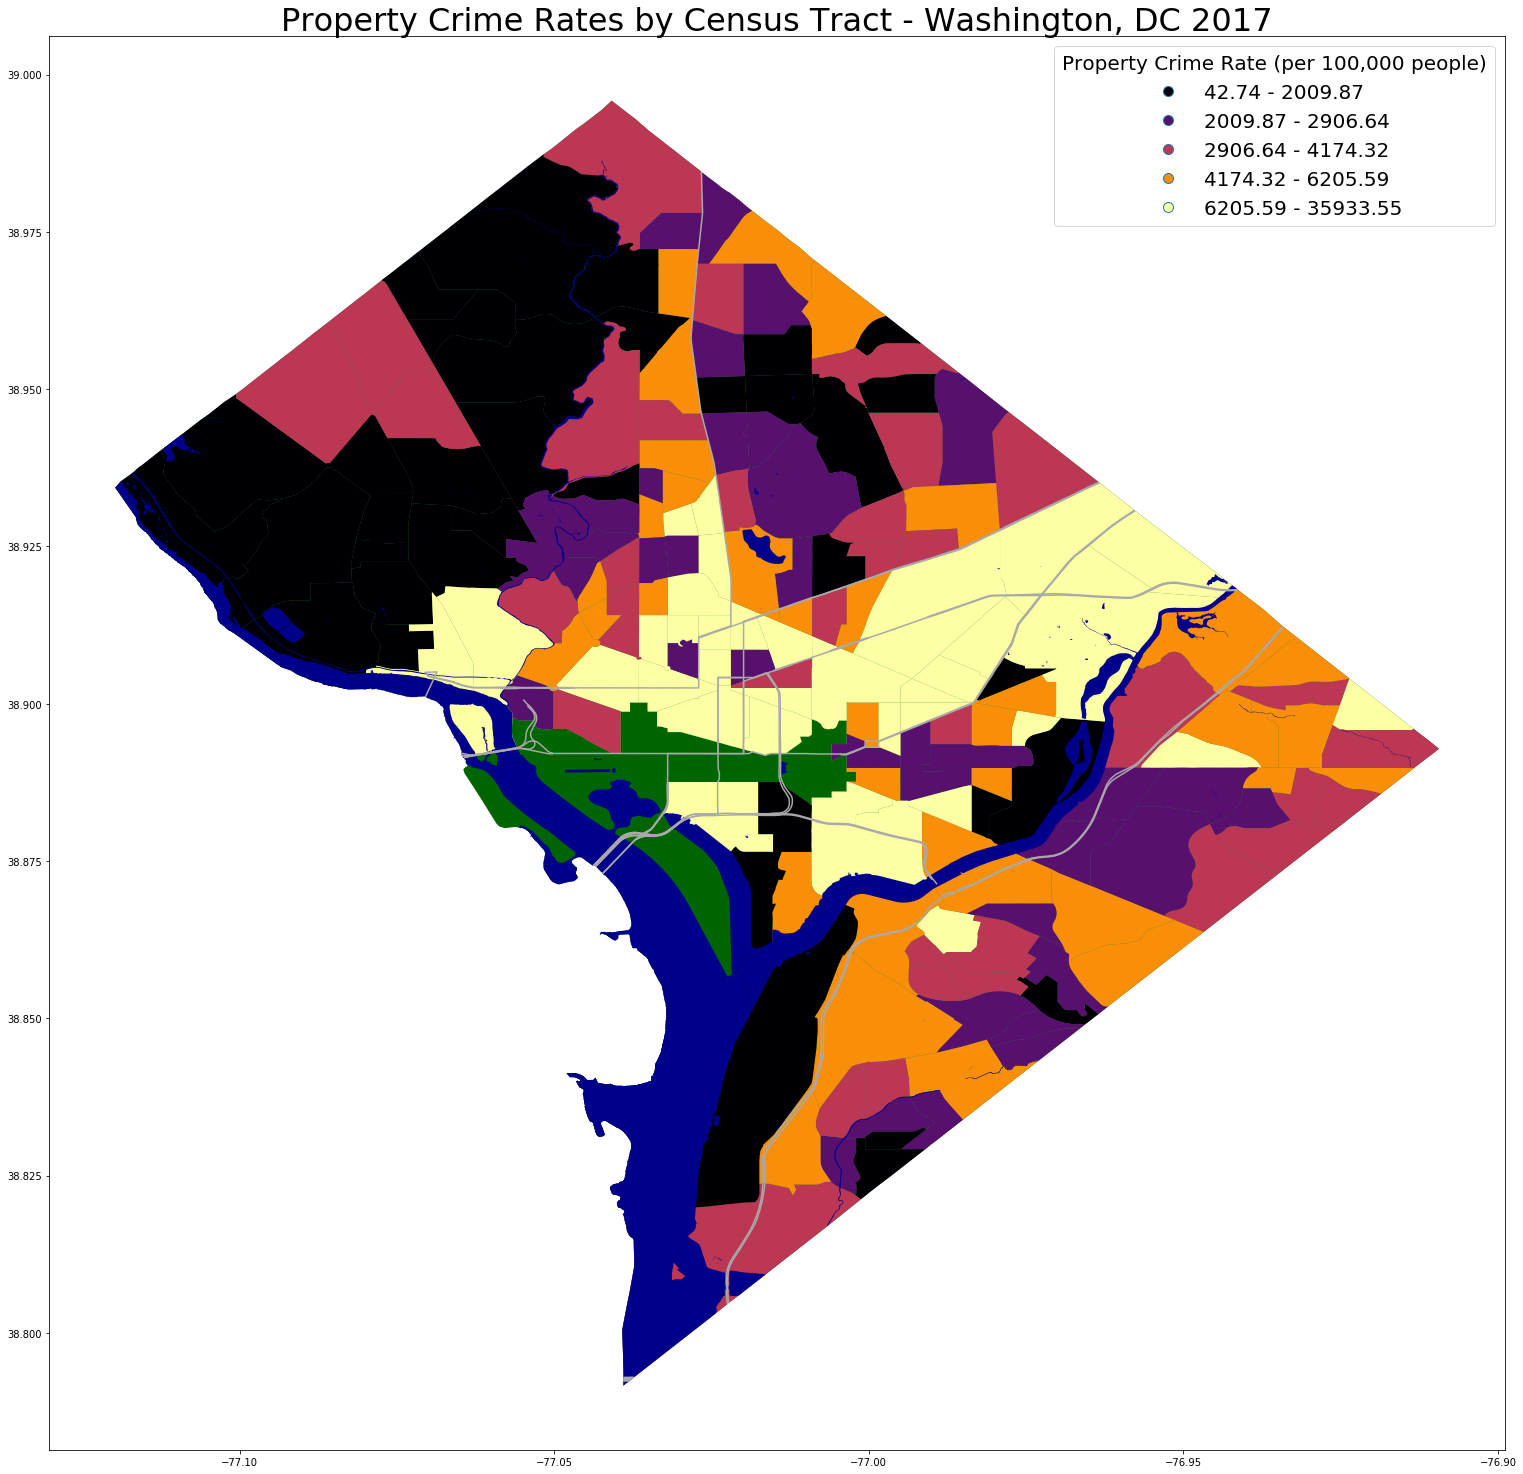

In [772]:
%matplotlib inline

for crime_type in 'violent_crime_rate', 'property_crime_rate':
    
    if crime_type == 'violent_crime_rate':
        title = 'Violent Crime Rates by Census Tract - Washington, DC 2017'
        leg_title = 'Violent Crime Rate (per 100,000 people)'
    
    if crime_type == 'property_crime_rate':
        title = 'Property Crime Rates by Census Tract - Washington, DC 2017'
        leg_title = 'Property Crime Rate (per 100,000 people)'

    base        = crimeratemap.plot(color='darkgreen',figsize=(40,26))
    crime_layer = crimeratemap_dropmall.plot(ax=base,column=crime_type,cmap='inferno',scheme='quantiles',k=5,legend=True,
                                       legend_kwds={'loc':1,'title':leg_title, 'prop':{'size':20}})
    water_layer = dcwatermap.plot(ax=crime_layer,color='darkblue',figsize=(40,26))
    road_layer  = dcroadmap.plot(ax=water_layer,color='darkgrey',figsize=(40,26))
    road_layer.set_title(title, color='black', fontdict={'fontsize':32})
    
    leg = crime_layer.get_legend()
    plt.setp(leg.get_title(), multialignment='left', size=20)
    

From the map of violent crime rates, it appears that the highest rates of violent crime are generally concentrated in the Southeast quandrant of the city, east of the Anacostia River, and in the Northeast quandrant for tracts south of Rhode Island Ave NE (also known as US Highway 1). There also exists a pocket in the downtown corridor. Stinkingly, the NW quandrant of the city demonstrates very low violent crime rates.

By comparison, property crime rates are much more concentrated in the city center, though again tracts located in the Northeast quadrant south of Rhode Island Ave NE demonstrate high property crime rates.

Now, I want to look at where exactly crimes were comitted in Washington, DC in 2017 and the minority makeup of those tracts. The Metropolitan Police Department provides x/y coordinates for each crime committed. In order to plot these values on my map, I will need to first convert the coordinates to latitude/longitude.

In [773]:
data[['xblock','yblock']].head()

xblock      yblock
0 400,212.000 136,281.000
1 394,912.000 137,666.000
2 398,437.000 143,648.000
3 401,305.000 138,586.000
4 397,921.000 135,525.000

Here, "inProj" stores the projection of the current coordinates, while "outProj" stores the projection (latitude/longitude) I am converting to, which I want to match the projection of the base layers.

In [774]:
from pyproj import Proj, transform

inProj = Proj(init='esri:102285')
outProj = Proj(crimeratemap.crs)

The line below converts the x/y coordinates provided into a single point column, which can then be set as the geometry in a geopandas dataframe.

In [775]:
from shapely.geometry import Point

data['LatLong'] = data.apply(lambda row: Point(transform(inProj, outProj, row['xblock'], row['yblock'])), axis=1)

In [776]:
data['LatLong'].head()

0    POINT (-76.99755621578377 38.89437604095529)
1    POINT (-77.05866107226434 38.90683791520591)
2    POINT (-77.01803392085112 38.96073891363611)
3     POINT (-76.9849525147478 38.91513934600918)
4    POINT (-77.02396293541074 38.88756327852006)
Name: LatLong, dtype: object

Convert the dataframe into a geopandas dataframe, setting the geometry as the column "LatLong" created above.

In [777]:
geo_crimepts = gpd.GeoDataFrame(data, geometry='LatLong')
geo_crimepts.head()

index     report_dat     shift       offense  method  \
0      0   2/6/17 20:11   EVENING   THEFT_OTHER  OTHERS   
1      1   6/3/17 12:54       DAY  THEFT_F_AUTO  OTHERS   
2      2    4/7/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
3      3   3/13/17 0:00  MIDNIGHT      HOMICIDE  OTHERS   
4      5  1/25/17 12:51       DAY  THEFT_F_AUTO  OTHERS   

                                       block  district     psa  ward anc  \
0      600 - 669 BLOCK OF MARYLAND AVENUE NE     1.000 107.000     6  6C   
1           2900 - 2999 BLOCK OF N STREET NW     2.000 206.000     2  2E   
2        5800  - 5899 BLOCK OF 4TH STREET NW     4.000 402.000     4  4B   
3     2000 - 2099 BLOCK OF FENWICK STREET NE     5.000 506.000     5  5D   
4  700 - 999 BLOCK OF INDEPENDENCE AVENUE SW     1.000 105.000     6  6D   

                       ...                      sex_abuse theft_f_auto  \
0                      ...                              0            0   
1                      ...                              0            1   
2                      ...                              0            0   
3                      ...                              0            0   
4                      ...                              0            1   

   theft_other property_crime  violent_crime  majmin_tract     income_cat  \
0            1              1              0             0    income_high   
1            0              1              0             0    income_high   
2            0              0              1             1  income_middle   
3            0              0              1             1     income_low   
4            0              1              0             1    income_high   

         unemp_cat     vacancy_cat  \
0  unemp_belownatl     vacancy_low   
1  unemp_belownatl    vacancy_high   
2  unemp_abovenatl     vacancy_low   
3  unemp_abovenatl    vacancy_high   
4  unemp_abovenatl  vacancy_middle   

                                        LatLong  
0  POINT (-76.99755621578377 38.89437604095529)  
1  POINT (-77.05866107226434 38.90683791520591)  
2  POINT (-77.01803392085112 38.96073891363611)  
3   POINT (-76.9849525147478 38.91513934600918)  
4  POINT (-77.02396293541074 38.88756327852006)  

[5 rows x 59 columns]

Set the projection of the geopandas dataframe to match that of the base layers.

In [778]:
geo_crimepts.crs = crimeratemap.crs

Create a dataframe, which will become a map layer, that only includes points for reported property crimes and plot.

In [779]:
geo_pcpts = geo_crimepts[geo_crimepts.property_crime==1].reset_index()
print(geo_pcpts.property_crime.value_counts())

1    28399
Name: property_crime, dtype: int64


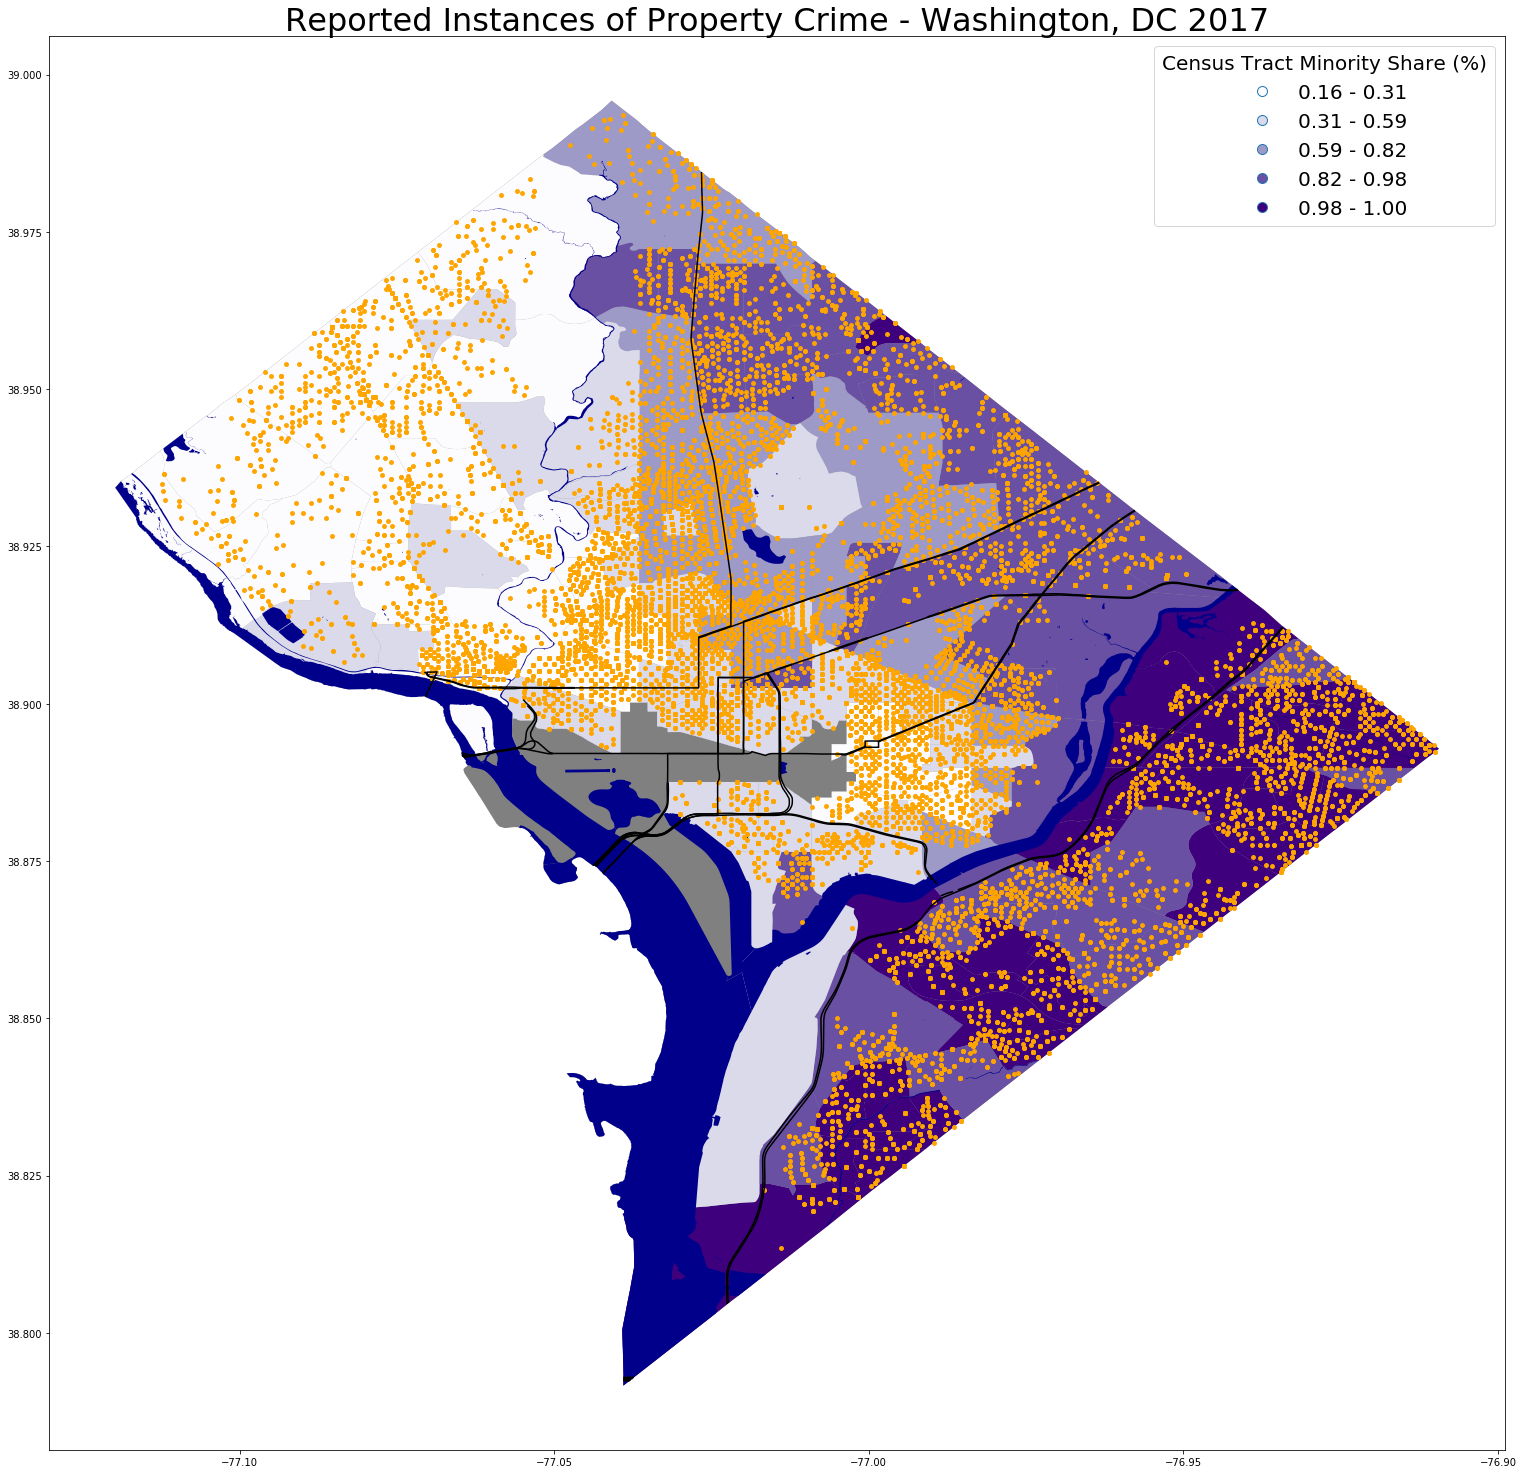

In [780]:
%matplotlib inline
base        = crimeratemap.plot(color='gray',figsize=(40,26))
race_layer = crimeratemap_dropmall.plot(ax=base,column='sharemin',cmap='Purples',scheme='quantiles',k=5,legend=True,
                                       legend_kwds={'loc': 1,'title':'Census Tract Minority Share (%)',  'prop':{'size':20}})                                                   
water_layer = dcwatermap.plot(ax=race_layer,color='darkblue',figsize=(40,26))
road_layer  = dcroadmap.plot(ax=water_layer,color='black',figsize=(40,26))

pts_layer = geo_pcpts.plot(ax=road_layer, marker="o", markersize=15, color='orange', figsize=(40,26))
pts_layer.set_title('Reported Instances of Property Crime - Washington, DC 2017', color='black', fontdict={'fontsize':32})

leg = race_layer.get_legend()
plt.setp(leg.get_title(), multialignment='left', size=20)

plt.show()

From the map above, property crime appears somewhat equally distributed across the district, with a particular concentration of reports, unsurprisingly, in the downtown corridor and around the main arteries of the city.

Here, I look at violent crime in total, as well as focusing on the top three types of violent crime committed in the district: assault with a dangerous weapon, robbery, and homicide. Again, for each crime type I create a dataframe that only includes points for the respective crime type.

In [781]:
geo_vcpts = geo_crimepts[geo_crimepts.violent_crime==1].reset_index()
print(geo_vcpts.violent_crime.value_counts())

geo_assaultweaponpts = geo_crimepts[geo_crimepts.assault_weapon==1].reset_index()
print(geo_assaultweaponpts.assault_weapon.value_counts())

geo_robberypts = geo_crimepts[geo_crimepts.robbery==1].reset_index()
print(geo_robberypts.robbery.value_counts())

geo_homicidepts = geo_crimepts[geo_crimepts.homicide==1].reset_index()
print(geo_homicidepts.homicide.value_counts())

1    4400
Name: violent_crime, dtype: int64
1    1840
Name: assault_weapon, dtype: int64
1    2155
Name: robbery, dtype: int64
1    113
Name: homicide, dtype: int64


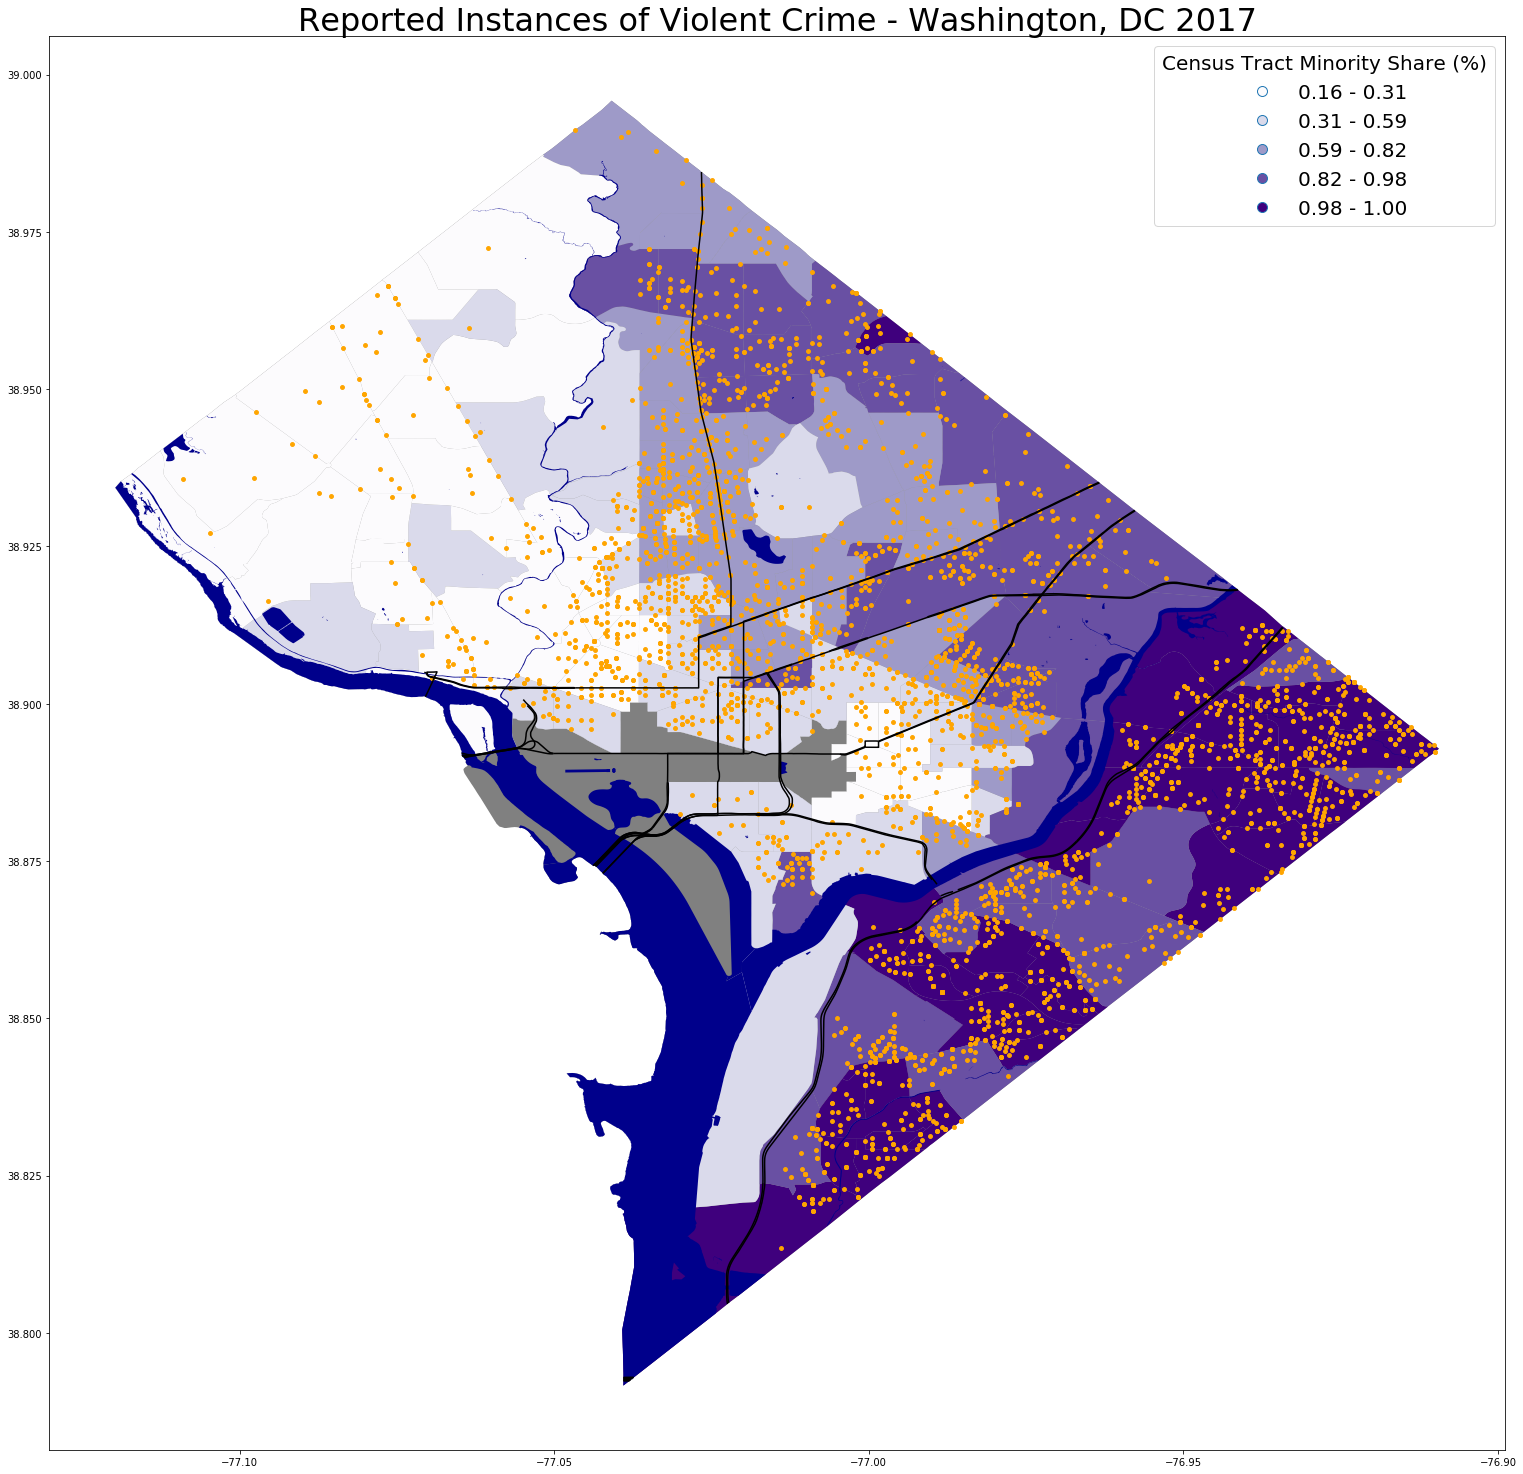

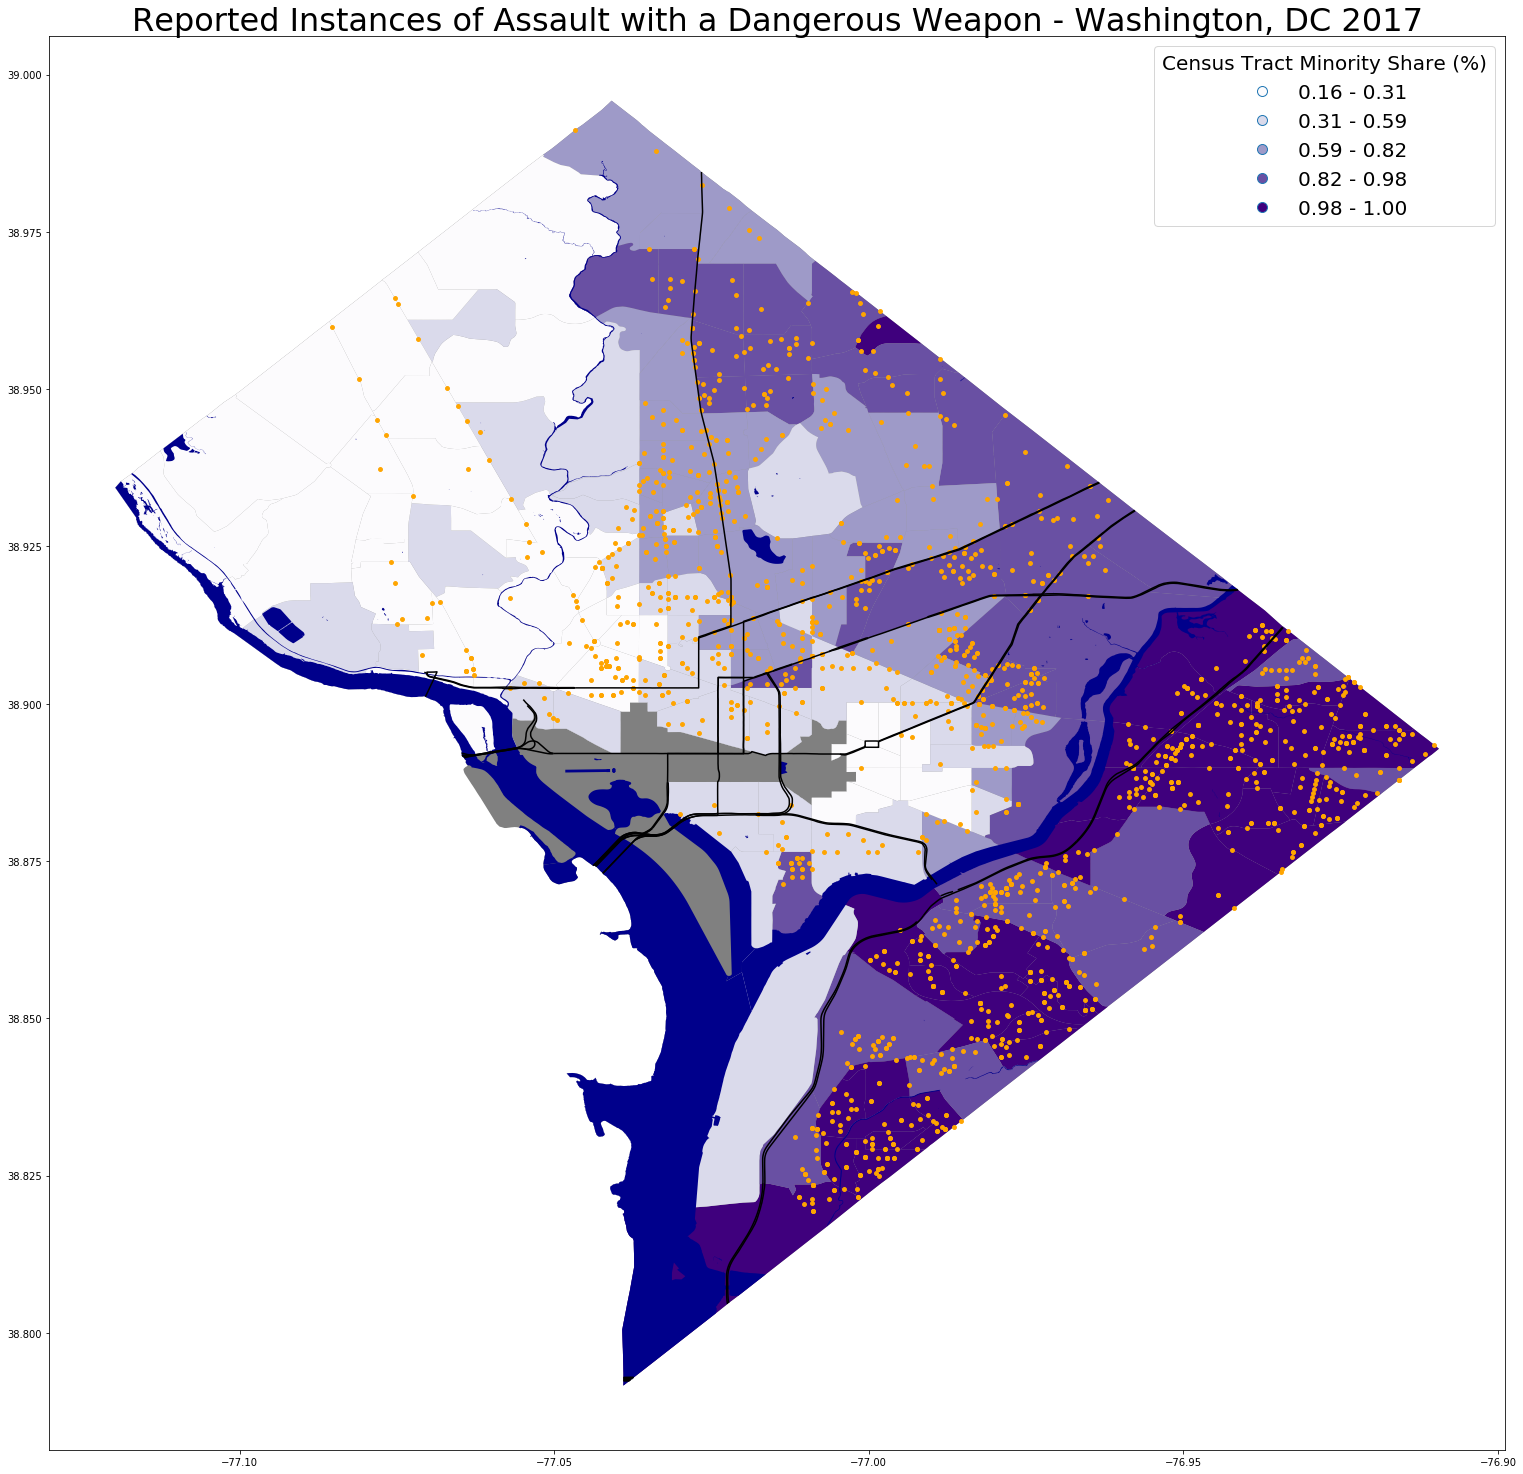

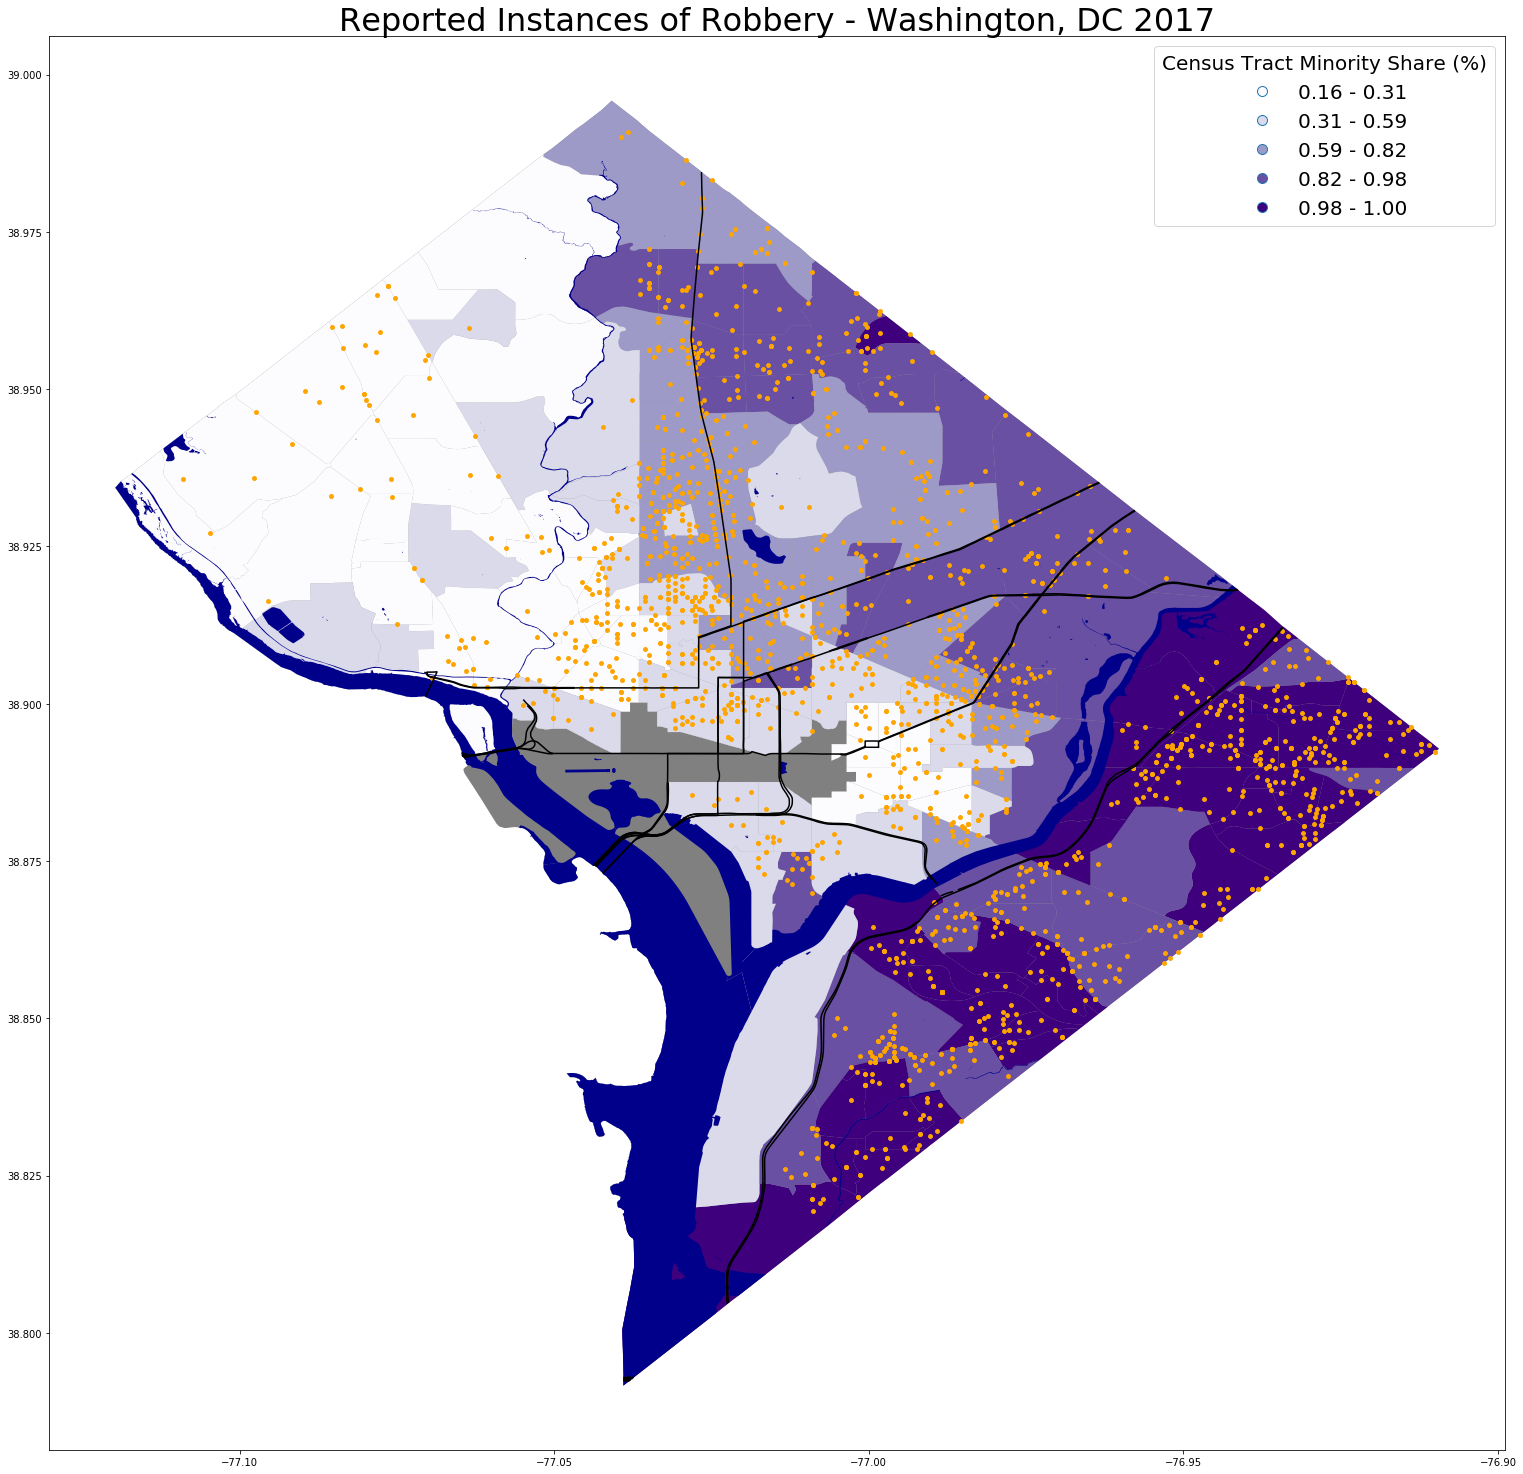

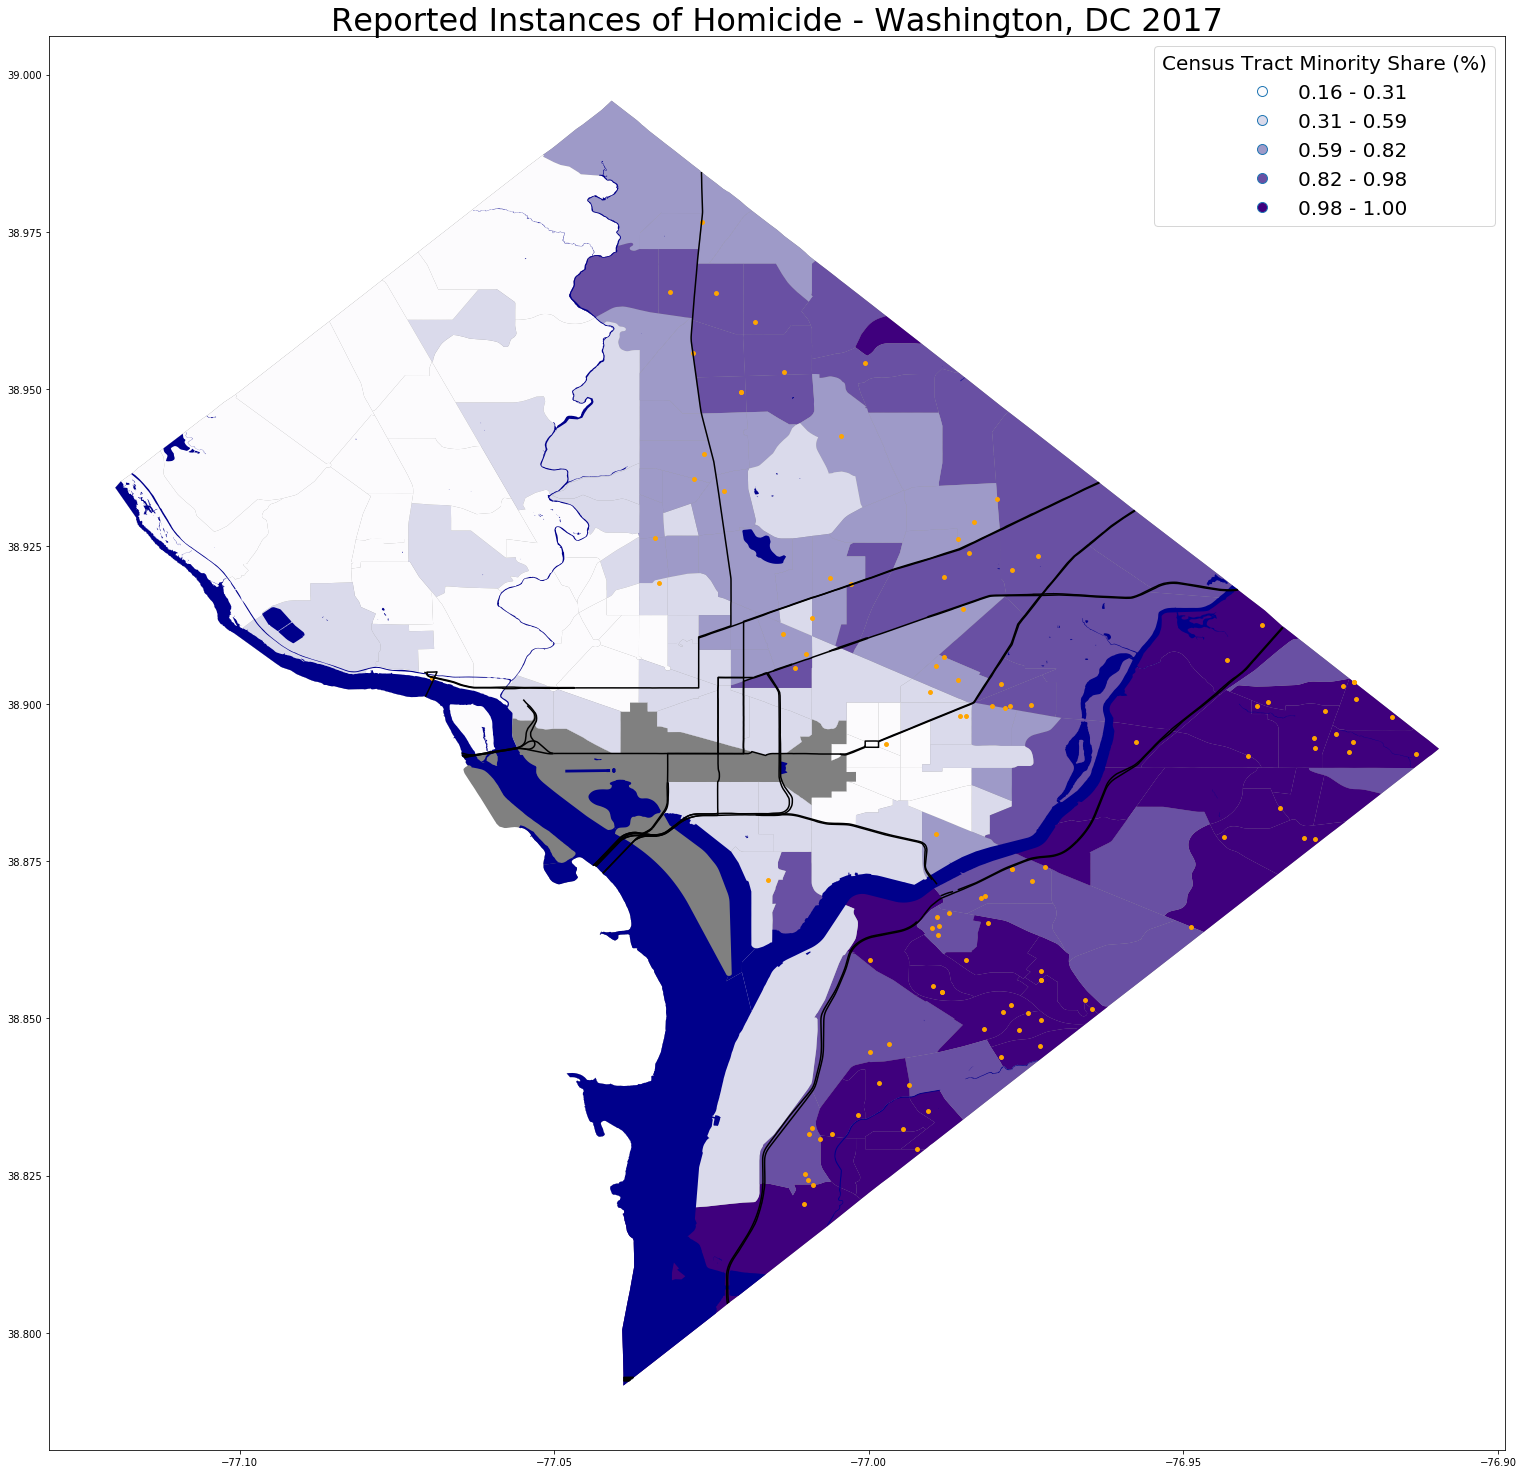

In [782]:
%matplotlib inline

vcframes = ['Violent Crime', 'Assault with a Dangerous Weapon', 'Robbery', 'Homicide']

for crime_type in vcframes:
    
    if crime_type == 'Violent Crime':
        df = geo_vcpts
    
    if crime_type == 'Assault with a Dangerous Weapon':
        df = geo_assaultweaponpts
        
    if crime_type == 'Robbery':
        df = geo_robberypts
        
    if crime_type == 'Homicide':
        df = geo_homicidepts

    base        = crimeratemap.plot(color='gray',figsize=(40,26))
    race_layer = crimeratemap_dropmall.plot(ax=base,column='sharemin',cmap='Purples',scheme='quantiles',k=5,legend=True,
                                           legend_kwds={'loc': 1,'title':'Census Tract Minority Share (%)',  'prop':{'size':20}})                                                   
    water_layer = dcwatermap.plot(ax=race_layer,color='darkblue',figsize=(40,26))
    road_layer  = dcroadmap.plot(ax=water_layer,color='black',figsize=(40,26))

    pts_layer = df.plot(ax=road_layer, marker="o", markersize=15, color='orange', figsize=(40,26))
    pts_layer.set_title(('Reported Instances of ' + crime_type + ' - Washington, DC 2017'), color='black', fontdict={'fontsize':32})

    leg = race_layer.get_legend()
    plt.setp(leg.get_title(), multialignment='left', size=20)

    plt.show()

From the maps above, violent crime appear more concentrated in high minority neighborhoods, particularly neighborhoods east of the Anacostia River. This is particularly striking for homicides, as only one homicide was committed in tracts in the lowest quantile of tract minority share, and the majority of homicides were committd in tracts with a minority share of 82% or greater. 